# **Milestone 2**
---

# **1. Introduction**

## **1.1. Author & Project**

- **Objective:** This program is made to predict the steam rating of a game

- **Dataset overview:** Our data is a result of combining 2 tables, it contains information about games released on steam

## **1.2. Problem Identification**

### 1.2.1. Problem Topic
- video game rating

### 1.2.2. Problem Background
- One factor that affects how well a game performs in terms of revenue is how well the game is perceived by players. 
- An intuitive and obvious way to gauge how well the game is perceived is by looking at a game's rating. But, up until now, the only way we can know what's the rating that our game get is by designing, developing, releasing it, waiting, and finally seeing what's the rating that our game gets. 
- This process takes a long time and a lot of cost. For our next game, we're trying to integrate data science throughout the development of our game, building a model that can predict video game's rating, giving our team an extra tool to evaluate our game based on features that affect a game's rating.

### 1.2.3. Problem Statement

Breaking down problem into sections,
1. `S - Specific`
    - create a model that can predict a game's rating
2. `M - Measurable`
    - getting less than 10% MAPE score and at least 75% R-squared score 
3. `A - Achievable`
    - identify the problem
    - understand the data
    - prepare the data for analyzation
    - analyze the data
    - prepare the data for machine learning
    - train model
    - evaluate model
    - deploy model
4. `R - Relevant`
    - by creating a model that can predict a game's rating, we can,
        - have a better idea of how well our game will be perceived by players in the middle of the development
5. `T - Time-bound`
    - model created within a work week

`Problem Statement` : 
- Our goal is to `create a model that can predict a game's rating`, `aiming to get 10% MAPE score and at least 75% R-squared score for our model`, `model created within a work week`, so that `our studio have a better idea of how well our game will be perceived by players in the middle of the development`
- Here are some steps that we'll take in order to `achieve` said goal:
    - identify the problem
    - understand the data
    - prepare the data for analyzation
    - analyze the data
    - prepare the data for machine learning
    - train model
    - evaluate model
    - deploy model

### 1.2.4. Problem Breakdown

Breaking down the problem into questions,
1. How is the data distribution of rating?
2. What is the correlation between estimated_total_players and rating?
3. What are the top 3 genres, tags, features, languages with the highest average rating?
4. How is the central tendency of price for games with either top 3 genres, tags, features, or languages?
5. What is the average estimated_total_players of each rating category?
6. How does average rating changes as the amount of supported languages increases?
7. How does average rating changes as the amount of estimated total players increase?

# **2. Import Libraries**

In [630]:
# data manipulation
import pandas as pd
import numpy as np
import re

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr, kendalltau
from feature_engine.outliers import Winsorizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# model definition & training
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor

# model evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# save model
import pickle
import json

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# show all columns
pd.set_option('display.max_columns', None)

# **3. Data Loading**

## **3.1. Load Data**

In [631]:
# load tables
df_main_raw = pd.read_csv('game_data_all.csv')
df_supp_raw = pd.read_csv('merged_data.csv')

# remove redundant columns and selected columns from support table
redundant_main_columns = ['Unnamed: 0', 'link', 'store_genres']
main_columns = [column for column in df_main_raw.columns.to_list() if column not in redundant_main_columns]
supp_columns = ['Title', 'Original Price', 'Supported Languages', 'Popular Tags', 'Game Features']

df_raw = df_main_raw[main_columns].merge(df_supp_raw[supp_columns], left_on='game', right_on='Title')
df_raw.drop(columns='Title', inplace=True)

df_raw.head()

,game,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date,Original Price,Supported Languages,Popular Tags,Game Features
0,Pizza Tower,2023-01-26,4529,19807,227,20034,96.39,Action (1),Tour De Pizza,Tour De Pizza,Engine.GameMaker; SDK.FMOD,2023-01-10,98.0,"3,101","3,606",4529,2023-03-25,$10.49,['English'],"['Great Soundtrack', '2D Platformer', 'Fast-Pa...","['Single-player', 'Steam Achievements', 'Full ..."
1,Resident Evil 4,2023-03-24,168191,61752,1616,63368,95.75,Action (1),CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine; SDK.AMD_GPU_Services,2023-03-29,97.0,"46,289","47,164",168191,2023-03-25,$59.99,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Horror', 'Survival Horror', 'Third...","['Single-player', 'Steam Achievements', 'Full ..."
2,The Murder of Sonic the Hedgehog,2023-03-31,15543,12643,213,12856,95.54,Casual (4),SEGA,SEGA,Engine.Unity; SDK.UnityBurst; SDK.cURL,2023-03-24,98.0,618,776,15543,2023-03-31,Free,['English'],"['Visual Novel', 'Casual', 'Point & Click', 'F...",['Single-player']
3,Pineapple on pizza,2023-03-28,1415,11717,209,11926,95.39,Indie (23),Majorariatto,Majorariatto,Engine.Unity; SDK.cURL,2023-03-22,98.0,101,101,1415,2023-03-28,Free,"['English', 'Spanish - Spain']","['Short', 'Free to Play', 'Dark Comedy', 'Expl...","['Single-player', 'Steam Achievements', 'Full ..."
4,Hi-Fi RUSH,2023-01-25,6132,14152,324,14476,95.09,Action (1),Bethesda Softworks,Tango Gameworks,Engine.Unreal; SDK.Intel_OID; SDK.Intel_XeSS; ...,2023-04-11,97.0,630,664,6132,2023-01-29,$17.99,"['English', 'French', 'Italian', 'German', 'Sp...","['Rhythm', 'Action', 'Singleplayer', 'Hack and...","['Single-player', 'Steam Achievements', 'Full ..."


## **3.2. Basic Data Exploration**

- **Insight:**
    - Some columns names are not using lowercase and snake case format
    - There are some irrelevant symbols in column `primary_genre`, `Original Price`, `Discounted Price`, `Supported Languages`, `Popular Tags`, `Game Features`
    - There are some categorical value in numeric columns (`Original Price`, `Discounted Price`)
    - Column `release`, `store_asset_mod_time`, `players_right_now`, `24_hour_peak`, `all_time_peak_date`, `Original Price`, `Discounted Price` with unsuitable data types
    - There are columns with multiple values
    - There are missing values in column `primary_genre`, `publisher`, `Developer`, `detected_technologies`, `store_asset_mod_time`, `review_percentage`, `players_right_now`, `24_hour_peak`
    - There are no duplicated row

**Show top 5 rows**

In [632]:
print('main table:')
display(df_raw.head(5))

main table:


,game,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date,Original Price,Supported Languages,Popular Tags,Game Features
0,Pizza Tower,2023-01-26,4529,19807,227,20034,96.39,Action (1),Tour De Pizza,Tour De Pizza,Engine.GameMaker; SDK.FMOD,2023-01-10,98.0,"3,101","3,606",4529,2023-03-25,$10.49,['English'],"['Great Soundtrack', '2D Platformer', 'Fast-Pa...","['Single-player', 'Steam Achievements', 'Full ..."
1,Resident Evil 4,2023-03-24,168191,61752,1616,63368,95.75,Action (1),CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine; SDK.AMD_GPU_Services,2023-03-29,97.0,"46,289","47,164",168191,2023-03-25,$59.99,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Horror', 'Survival Horror', 'Third...","['Single-player', 'Steam Achievements', 'Full ..."
2,The Murder of Sonic the Hedgehog,2023-03-31,15543,12643,213,12856,95.54,Casual (4),SEGA,SEGA,Engine.Unity; SDK.UnityBurst; SDK.cURL,2023-03-24,98.0,618,776,15543,2023-03-31,Free,['English'],"['Visual Novel', 'Casual', 'Point & Click', 'F...",['Single-player']
3,Pineapple on pizza,2023-03-28,1415,11717,209,11926,95.39,Indie (23),Majorariatto,Majorariatto,Engine.Unity; SDK.cURL,2023-03-22,98.0,101,101,1415,2023-03-28,Free,"['English', 'Spanish - Spain']","['Short', 'Free to Play', 'Dark Comedy', 'Expl...","['Single-player', 'Steam Achievements', 'Full ..."
4,Hi-Fi RUSH,2023-01-25,6132,14152,324,14476,95.09,Action (1),Bethesda Softworks,Tango Gameworks,Engine.Unreal; SDK.Intel_OID; SDK.Intel_XeSS; ...,2023-04-11,97.0,630,664,6132,2023-01-29,$17.99,"['English', 'French', 'Italian', 'German', 'Sp...","['Rhythm', 'Action', 'Singleplayer', 'Hack and...","['Single-player', 'Steam Achievements', 'Full ..."


**Show basic column infos**

In [633]:
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50030 entries, 0 to 50029
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game                   50030 non-null  object 
 1   release                50030 non-null  object 
 2   peak_players           50030 non-null  int64  
 3   positive_reviews       50030 non-null  int64  
 4   negative_reviews       50030 non-null  int64  
 5   total_reviews          50030 non-null  int64  
 6   rating                 50030 non-null  float64
 7   primary_genre          50029 non-null  object 
 8   publisher              49738 non-null  object 
 9   developer              49975 non-null  object 
 10  detected_technologies  44553 non-null  object 
 11  store_asset_mod_time   49917 non-null  object 
 12  review_percentage      35407 non-null  float64
 13  players_right_now      50026 non-null  object 
 14  24_hour_peak           50026 non-null  object 
 15  al

None

**Check for missing values**

In [634]:
display(df_raw.isnull().sum())

game                         0
release                      0
peak_players                 0
positive_reviews             0
negative_reviews             0
total_reviews                0
rating                       0
primary_genre                1
publisher                  292
developer                   55
detected_technologies     5477
store_asset_mod_time       113
review_percentage        14623
players_right_now            4
24_hour_peak                 4
all_time_peak                0
all_time_peak_date           4
Original Price               0
Supported Languages          0
Popular Tags                 0
Game Features                0
dtype: int64

**Check for duplicated rows**

In [635]:
duplicated_amount = df_raw.duplicated().sum()
print(f'duplicated amount: {duplicated_amount}')

duplicated amount: 0


## **3.3. Data Pre-Processing**

- **Insight:**
    - Change column names to lowercase and use snake_case
        - for easier access/query
    - Remove irrelevant symbols in column `primary_genre`, `Original Price`, `Discounted Price`, `supported_languages`, `popular_tags`, `game_features`, `players_right_now`, `24_hour_peak`, `players_right_now`
        - because models can't recognize these symbols
    - Remove categorical value in numeric columns (`original_price`, `discounted_price`)
        - because column is numerical
    - Change column `release`, `store_asset_mod_time`, `players_right_now`, `24_hour_peak`, `all_time_peak_date`, `Original Price`, `Discounted Price` to suitable data types
        - so that models can process these columns as the right data type
    - Turn values in columns with multiple values into a list instead of string
        - so that it becomes an actual multiple values
    - (Will be postponed to feature engineering) explode columns with multiple values
        - because multiple values in a cell would create unnecessary pattern 
    - (Will be postponed to feature engineering) impute missing values in column `primary_genre`, `publisher`, `developer`, `detected_technologies`
        - because there's 'unknown' value in these columns
    - (Will be postponed to feature engineering) drop missing values in column `store_asset_mod_time`, `review_percentage`, `players_right_now`, `24_hour_peak`
        - because we couldn't find any pattern and the correlation with other column

In [636]:
# make a copy of df
df_cleaned = df_raw.copy()

# rename column names to use snake case
column_names = list(df_cleaned.columns.str.replace(' ', ''))
column_names_snake_case = []

for cn in column_names:
    column_names_snake_case.append(re.sub(r'(?<!^)(?=[A-Z])', '_', cn).lower())

df_cleaned.columns = column_names_snake_case

# remove irrelevant symbols
df_cleaned['primary_genre'] = df_cleaned['primary_genre'].str.split(' ')
df_cleaned["primary_genre"] = df_cleaned['primary_genre'].str[0]
df_cleaned['original_price'] = df_cleaned['original_price'].str.replace('$', '')
df_cleaned['original_price'] = df_cleaned['original_price'].str.replace(',', '')
df_cleaned['players_right_now'] = df_cleaned['players_right_now'].str.replace(',', '')
df_cleaned['24_hour_peak'] = df_cleaned['24_hour_peak'].str.replace(',', '')

to_remove_symbols = ['[', ']', "'", ' ']
columns_w_symbols = ['supported_languages', 'popular_tags', 'game_features']

for column in columns_w_symbols:
    for symbol in to_remove_symbols:
        df_cleaned[column] = df_cleaned[column].str.replace(symbol, '')

# remove categorical values in numeric columns
df_cleaned['original_price'][df_cleaned['original_price'] == 'Free'] = 0

# change data types
df_cleaned['release'] = pd.to_datetime(df_cleaned['release'], format='%Y-%m-%d')
df_cleaned['store_asset_mod_time'] = pd.to_datetime(df_cleaned['release'], format='%Y-%m-%d')
df_cleaned['players_right_now'] = pd.to_numeric(df_cleaned['players_right_now'], downcast='integer').round(0)
df_cleaned['24_hour_peak'] = pd.to_numeric(df_cleaned['24_hour_peak'], downcast='integer').round(0)
df_cleaned['all_time_peak_date'] = pd.to_datetime(df_cleaned['all_time_peak_date'], format='%Y-%m-%d')
df_cleaned['original_price'] = pd.to_numeric(df_cleaned['original_price'], downcast='float').round(2)

# turn multiple values into actual multiple values
df_cleaned['supported_languages'] = df_cleaned['supported_languages'].str.split(',')
df_cleaned['popular_tags'] = df_cleaned['popular_tags'].str.split(',')
df_cleaned['game_features'] = df_cleaned['game_features'].str.split(',')
df_cleaned['detected_technologies'] = df_cleaned['detected_technologies'].str.split(';')

# show the difference before and after cleaning
print("before cleaning: ")
display(df_raw.head(3))
print('after cleaning: ')
display(df_cleaned.head(3))

print('data types: ')
display(pd.DataFrame({
    'column' : list(df_cleaned.columns),
    'dtype before cleaning' : list(df_raw.dtypes),
    'dtype after cleaning' : list(df_cleaned.dtypes)
}))

# export cleaned data to csv
df_cleaned.to_csv('cleaned.csv')

before cleaning: 


,game,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date,Original Price,Supported Languages,Popular Tags,Game Features
0,Pizza Tower,2023-01-26,4529,19807,227,20034,96.39,Action (1),Tour De Pizza,Tour De Pizza,Engine.GameMaker; SDK.FMOD,2023-01-10,98.0,"3,101","3,606",4529,2023-03-25,$10.49,['English'],"['Great Soundtrack', '2D Platformer', 'Fast-Pa...","['Single-player', 'Steam Achievements', 'Full ..."
1,Resident Evil 4,2023-03-24,168191,61752,1616,63368,95.75,Action (1),CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine; SDK.AMD_GPU_Services,2023-03-29,97.0,"46,289","47,164",168191,2023-03-25,$59.99,"['English', 'French', 'Italian', 'German', 'Sp...","['Action', 'Horror', 'Survival Horror', 'Third...","['Single-player', 'Steam Achievements', 'Full ..."
2,The Murder of Sonic the Hedgehog,2023-03-31,15543,12643,213,12856,95.54,Casual (4),SEGA,SEGA,Engine.Unity; SDK.UnityBurst; SDK.cURL,2023-03-24,98.0,618,776,15543,2023-03-31,Free,['English'],"['Visual Novel', 'Casual', 'Point & Click', 'F...",['Single-player']


after cleaning: 


,game,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date,original_price,supported_languages,popular_tags,game_features
0,Pizza Tower,2023-01-26,4529,19807,227,20034,96.39,Action,Tour De Pizza,Tour De Pizza,"[Engine.GameMaker, SDK.FMOD]",2023-01-26,98.0,3101.0,3606.0,4529,2023-03-25,10.490000,[English],"[GreatSoundtrack, 2DPlatformer, Fast-Paced, Ca...","[Single-player, SteamAchievements, Fullcontrol..."
1,Resident Evil 4,2023-03-24,168191,61752,1616,63368,95.75,Action,CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,"[Engine.RE_Engine, SDK.AMD_GPU_Services]",2023-03-24,97.0,46289.0,47164.0,168191,2023-03-25,59.990002,"[English, French, Italian, German, Spanish-Spa...","[Action, Horror, SurvivalHorror, Third-PersonS...","[Single-player, SteamAchievements, Fullcontrol..."
2,The Murder of Sonic the Hedgehog,2023-03-31,15543,12643,213,12856,95.54,Casual,SEGA,SEGA,"[Engine.Unity, SDK.UnityBurst, SDK.cURL]",2023-03-31,98.0,618.0,776.0,15543,2023-03-31,0.000000,[English],"[VisualNovel, Casual, Point&Click, FreetoPlay,...",[Single-player]


data types: 


,column,dtype before cleaning,dtype after cleaning
0,game,object,object
1,release,object,datetime64[ns]
2,peak_players,int64,int64
3,positive_reviews,int64,int64
4,negative_reviews,int64,int64
5,total_reviews,int64,int64
6,rating,float64,float64
7,primary_genre,object,object
8,publisher,object,object
9,developer,object,object


# **4. Exploratory Data Analysis (EDA)**

## *4.1. How is the data distribution of rating?*

- **Insight:**
    - Rating data is `normally distributed` since our absolute skewness is not greater than 0.5

skewness:  -0.4266495475741252


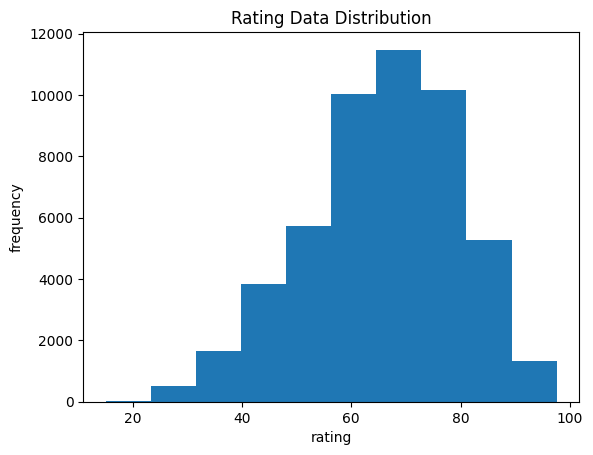

In [637]:
# copy df
df_eda_1 = df_cleaned.copy()

# show skewness
print('skewness: ', df_eda_1['rating'].skew())

# draw plot
plt.hist(x=df_eda_1['rating'])

# set title
plt.title('Rating Data Distribution')

# set label
plt.xlabel('rating')
plt.ylabel('frequency')

# show plot
plt.show()

## *4.2. What is the correlation between estimated_total_players and rating?*

- **Note:**
    - Because our data doesn't inform us about the total_player, we'll get the data by estimating total_player by the formula provided [here](https://www.themultiplayergroup.com/news/using-steam-reviews-to-estimate-player-numbers-an-intuitive-method)
    - The correlation coefficient that we'll use is spearman because our 2 variables are numeric and not normally distributed
- **Insight:**
    - estimated_total_player and rating are `positively correlated` (an increase in estimated_total_player would be followed by an increase in rating)
        - The correlation is `by real` (p-value: 0.00 which is less than 0.05 based on 95% confidence level) 

estimated_total_players skewness: 147.33305720941067
rho-correlation: 0.46, p-value: 0.0


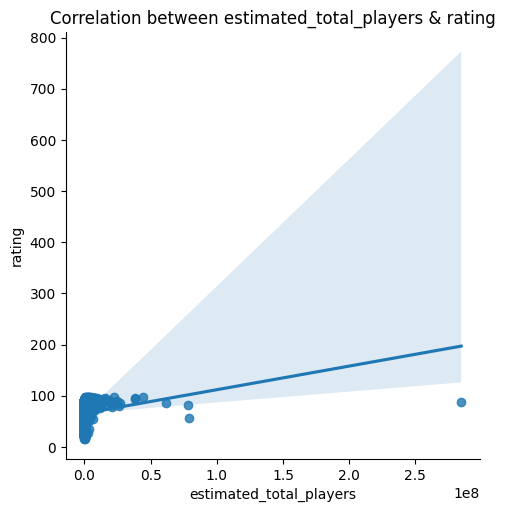

In [638]:
# copy df
df_eda_2 = df_cleaned.copy()

# get estimated total player
inflations = []
for i in df_eda_2['release'].dt.year:
    if i < 2017:
        inflations.append(1.5)
    elif i < 2018:
        inflations.append(2.2)
    elif i < 2019:
        inflations.append(2.7)
    else:
        inflations.append(3.4)

adjusted_reviews = df_eda_2['total_reviews'] / inflations
adjusted_reviews = adjusted_reviews.astype(int)

players_per_review = []
for i in df_eda_2['total_reviews']:
    if i < 100_000:
        players_per_review.append(80)
    else:
        players_per_review.append(60)

for i in range(len(df_eda_2['original_price'])):
    if df_eda_2['original_price'][i] < 5:
        players_per_review[i] += 10
    else:
        players_per_review[i] -= 5

game_age = 2024 - df_eda_2['release'].dt.year
for i in range(len(game_age)):
    if game_age[i] > 5:
        players_per_review[i] += 10
    else:
        players_per_review[i] -= 5

positive_percentage = (df_eda_2['positive_reviews'] / df_eda_2['total_reviews']) * 100
for i in range(len(positive_percentage)):
    if positive_percentage[i] < 50:
        players_per_review[i] += 10
    elif positive_percentage[i] >= 80:
        players_per_review[i] -= 5

estimated_total_players = adjusted_reviews * players_per_review

# add estimated_total_players to df
df_eda_2['estimated_total_players'] = estimated_total_players

# show skewness
print(f'estimated_total_players skewness: {df_eda_2["estimated_total_players"].skew()}')

# show corr coef & p val
corr_rho, pval_s = spearmanr(df_eda_2['estimated_total_players'], df_eda_2['rating'])
print(f"rho-correlation: {corr_rho:.2f}, p-value: {pval_s}")

# draw plot
sns.lmplot(data=df_eda_2,x='estimated_total_players', y='rating')

# set title
plt.title('Correlation between estimated_total_players & rating')

# show plot
plt.show()

## *4.3. What are the top 3 genres, tags, features, languages with the highest average rating?*

- **Insight:**
    - Based on the rating,
        - the top 3 genres are `Design`, `Free`, `Adventure`
        - the top 3 tags are `Birds`, `SteamMachine`, `Well-Written`
        - the top 3 features are `DownloadableContent`, `Mods`, `RemotePlayOnTablet`
        - the top 3 languages are `Portugese-Brazil`, `Japanese`, `Korean` 

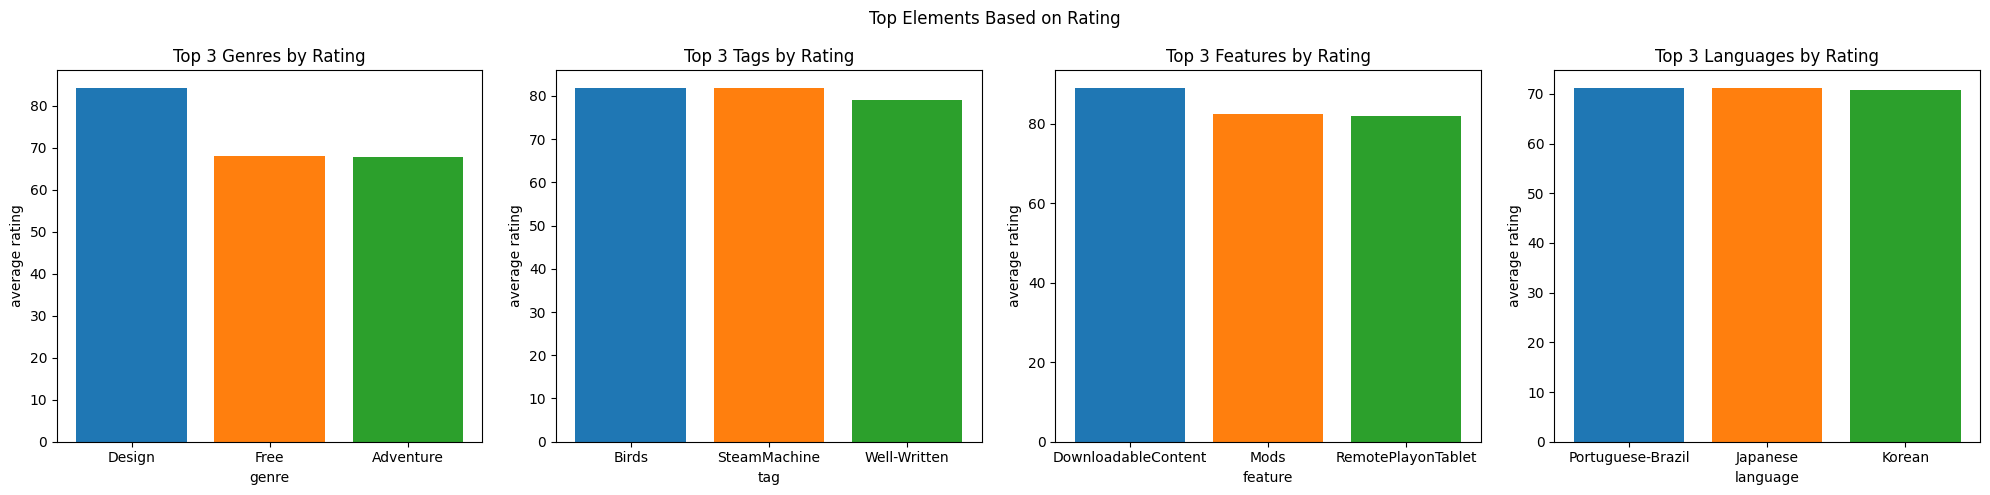

In [639]:
# copy df
df_eda_3 = df_cleaned.copy()

# get genre plot data
df_eda_3_genre = (df_eda_3
                  .groupby(by='primary_genre', as_index=False)
                  ['rating'].mean()
                  .sort_values(by='rating', ascending=False))
df_eda_3_genre = df_eda_3_genre[df_eda_3_genre['primary_genre'] != 'Unknown'].head(3)

# get tags plot data
df_eda_3_tags = (df_eda_3
                 .explode(column='popular_tags')
                 .groupby(by='popular_tags', as_index=False)['rating'].mean()
                 .sort_values(by='rating', ascending=False))
df_eda_3_tags = df_eda_3_tags[df_eda_3_tags['popular_tags'] != ''].head(3)

# get features plot data
df_eda_3_features = (df_eda_3
                 .explode(column='game_features')
                 .groupby(by='game_features', as_index=False)['rating'].mean()
                 .sort_values(by='rating', ascending=False))
df_eda_3_features = df_eda_3_features[df_eda_3_features['game_features'] != 'Mods(requireHL2)'].head(3)

# get languages plot data
df_eda_3_languages = (df_eda_3
                 .explode(column='supported_languages')
                 .groupby(by='supported_languages', as_index=False)['rating'].mean()
                 .sort_values(by='rating', ascending=False))
df_eda_3_languages = df_eda_3_languages[~df_eda_3_languages['supported_languages'].isin(['(allwithfullaudiosupport)', '', '#lang_slovakian'])].head(3)

# create sub plots
fig, axs = plt.subplots(ncols=4, figsize=[20, 5])

# set sup title
fig.suptitle('Top Elements Based on Rating')

# draw plots
axs[0].bar(data=df_eda_3_genre, x='primary_genre', height='rating', color=sns.color_palette('tab10'))
axs[0].set_title('Top 3 Genres by Rating')
axs[0].set_xlabel('genre')
axs[0].set_ylabel('average rating')

axs[1].bar(data=df_eda_3_tags, x='popular_tags', height='rating', color=sns.color_palette('tab10'))
axs[1].set_title('Top 3 Tags by Rating')
axs[1].set_xlabel('tag')
axs[1].set_ylabel('average rating')

axs[2].bar(data=df_eda_3_features, x='game_features', height='rating', color=sns.color_palette('tab10'))
axs[2].set_title('Top 3 Features by Rating')
axs[2].set_xlabel('feature')
axs[2].set_ylabel('average rating')

axs[3].bar(data=df_eda_3_languages, x='supported_languages', height='rating', color=sns.color_palette('tab10'))
axs[3].set_title('Top 3 Languages by Rating')
axs[3].set_xlabel('language')
axs[3].set_ylabel('average rating')

# set layout
plt.tight_layout()

# show plot
plt.show()

## *4.4. How is the central tendency of price for games with either top 3 genres, tags, features, or languages?*

- **Insight:**
    - The central tendency of price for games with either top 3 games, tags, features, or languages are,
        - mean: `67.82`
        - median: `69.20`
        - mode: `50.00`

mean: 67.82
median: 69.20
mode: 50.00


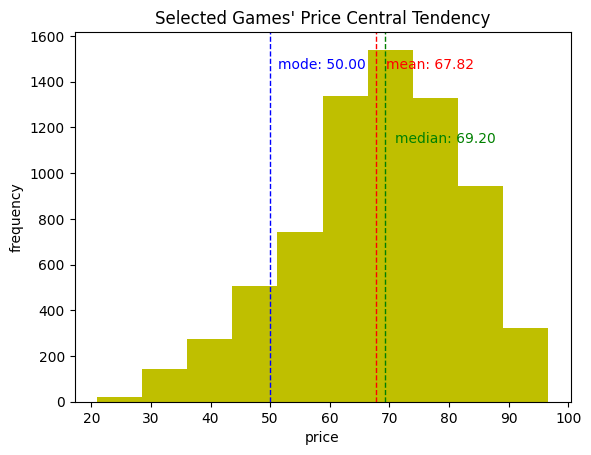

In [640]:
# copy df
df_eda_4 = df_cleaned.copy()

# get data with top 3 genres, tags, features, and languages
top_genres = df_eda_3_genre['primary_genre']
top_tags = df_eda_3_tags['popular_tags']
top_features = df_eda_3_features['game_features']
top_languages = df_eda_3_languages['supported_languages']

df_top = df_eda_4[df_eda_4['primary_genre'].isin(top_genres) | 
                  df_eda_4['popular_tags'].isin(top_tags) |
                  df_eda_4['game_features'].isin(top_features) |
                  df_eda_4['supported_languages'].isin(top_languages)]

# draw plot
plt.hist(df_top['rating'], color='y')

# set title
plt.title("Selected Games' Price Central Tendency")

# add central tendency lines & texts
min_ylim, max_ylim = plt.ylim()

plt.axvline(df_top['rating'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.text(df_top['rating'].mean()*1.025, max_ylim*0.9, f'mean: {df_top["rating"].mean():.2f}', color='r')

plt.axvline(df_top['rating'].median(), color='g', linestyle='dashed', linewidth=1)
plt.text(df_top['rating'].median()*1.025, max_ylim*0.7, f'median: {df_top["rating"].median():.2f}', color='g')

plt.axvline(df_top['rating'].mode()[0], color='b', linestyle='dashed', linewidth=1)
plt.text(df_top['rating'].mode()[0]*1.025, max_ylim*0.9, f'mode: {df_top["rating"].mode()[0]:.2f}', color='b')

# show central tendency
print(f'mean: {df_top["rating"].mean():.2f}')
print(f'median: {df_top["rating"].median():.2f}')
print(f'mode: {df_top["rating"].mode()[0]:.2f}')

# set axes' labels
plt.xlabel('price')
plt.ylabel('frequency')

# show plot
plt.show()

## *4.5. What is the average estimated_total_players of each rating category?*

- **Note:**
    - Rules on rating category following [source](https://steamcommunity.com/discussions/forum/0/1744482869761322402/) are as such, 
<center>

|%score  |   #reviews   |  rating  |   confidence
|---|---|---|---|
|95 - 100 | 500+ reviews | positive | overwhelmingly
|85 - 100 |  50+ reviews | positive | very
|80 - 100 |  10+ reviews | positive | -
|70 -  79 |  10+ reviews | positive | mostly
|40 -  69 |  10+ reviews | mixed    | -
|20 -  39 |  10+ reviews | negative | mostly
| 0 -  19 |  10+ reviews | negative | -
| 0 -  19 |  50+ reviews | negative | very
| 0 -  19 | 500+ reviews | negative | overwhelmingly

</center>

- **Insight:**
    - There is a significant increase in estimated total players after rating category goes beyond mixed (positive and above)
    - The average estimated total players of each rating category are as such,
<center>

|rating_category|estimated_total_players|
|---|---|
|overwhelmingly_negative |36985|
|very_negative |10680|
|negative |570|
|mostly_negative |12587|
|mixed |18761|
|mostly_positive |32062|
|positive |86524|
|very_positive |431295|
|overwhelmingly_positive |3323016|

</center>

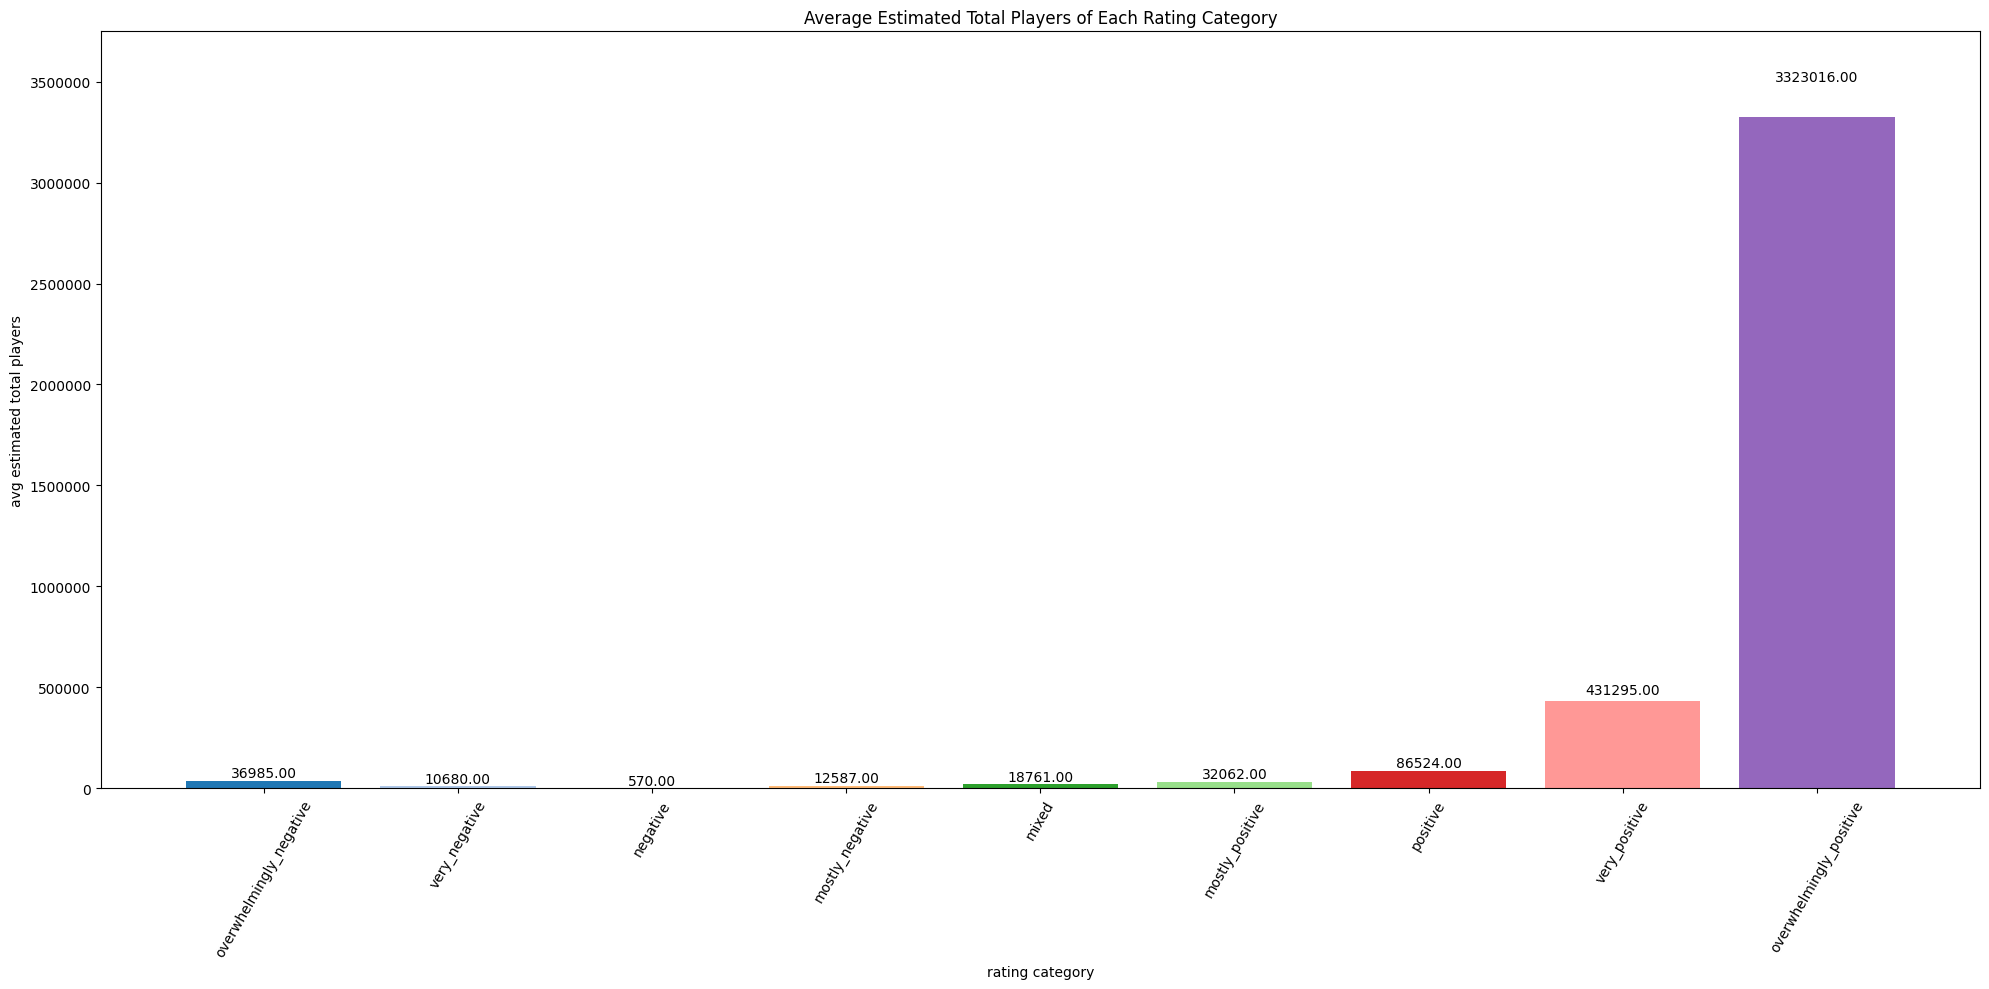

In [641]:
# copy df
df_eda_5 = df_cleaned.copy()

# get rating category
rating_category_data = []
for i in range(len(df_eda_5)):
    rating = df_eda_5['rating'][i]
    review = df_eda_5['total_reviews'][i]
    
    if review < 10:
        rating_category_data.append('unrated')
    else:
        if rating < 20:
            if review < 50:
                rating_category_data.append('negative')
            elif review < 500:
                rating_category_data.append('very_negative')
            else:
                rating_category_data.append('overwhelmingly_negative')
        elif rating < 40:
            rating_category_data.append('mostly_negative')
        elif rating < 70:
            rating_category_data.append('mixed')
        elif rating < 80:
            rating_category_data.append('mostly_positive')
        elif rating >= 95 and review >= 500:
            rating_category_data.append('overwhelmingly_positive')
        elif rating >= 85 and review >= 50:
            rating_category_data.append('very_positive')
        else:
            rating_category_data.append('positive')

# add rating_category and estimated_total_players to df
df_eda_5['rating_category'] = rating_category_data
df_eda_5['estimated_total_players'] = estimated_total_players

# group df by rating_category and avg players_right_now
df_eda_5_grouped = df_eda_5.groupby(by='rating_category', as_index=False)[['estimated_total_players', 'rating']].mean().sort_values('rating', ascending=True)
df_eda_5_grouped.drop(columns=['rating'], inplace=True)
df_eda_5_grouped.drop(index=df_eda_5_grouped[df_eda_5_grouped['rating_category']=='unrated'].index, inplace=True)
df_eda_5_grouped['estimated_total_players'] = df_eda_5_grouped['estimated_total_players'].astype(int)

# draw plot
plt.bar(x=df_eda_5_grouped['rating_category'], height=df_eda_5_grouped['estimated_total_players'], color=sns.color_palette('tab20'))

# add bar label
ax = plt.gca()
rects = ax.patches
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            f'{height:.2f}',
            ha='center', va='bottom')

# set plot formatting
plt.title('Average Estimated Total Players of Each Rating Category')

plt.xlabel('rating category')
plt.ylabel('avg estimated total players')

ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)

plt.gcf().set_size_inches([20, 10])

plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

plt.ylim(0, 3_750_000)

# show plot
plt.show()

## *4.6. How does average rating changes as the amount of supported languages increases?*

- **Insight:**
    - Generally, the average rating `barely increases` as the amount of supported languages increases
    - There is a `diminishing return` in rating when the amount of supported languages goes past beyond 10

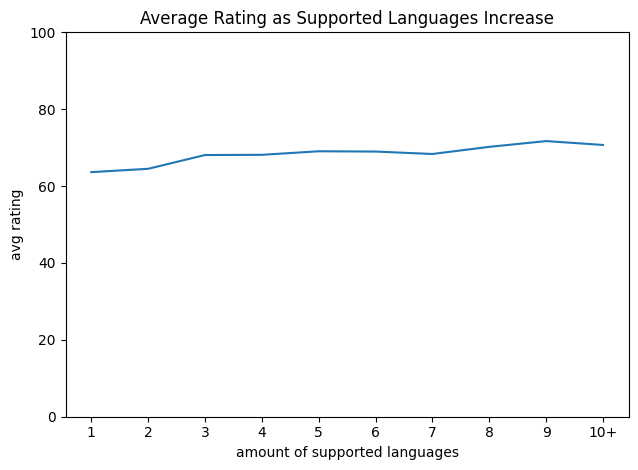

In [642]:
# make a copy of df
df_eda_6 = df_cleaned.copy()

# get languages amount
languages_amount = []
for i in df_eda_6['supported_languages']:
    if len(i) >= 10:
        languages_amount.append('10+')
    else:
        languages_amount.append(f'{len(i)}')

# add languages_amount to df
df_eda_6['languages_amount'] = languages_amount

# group df by languages_amount and avg rating
df_eda_6_grouped = df_eda_6.groupby(by='languages_amount', as_index=False)['rating'].mean()

# sort by languages_amount
df_eda_6_grouped['order'] = pd.Categorical(
    df_eda_6_grouped['languages_amount'],
    # categories=[str(i) for i in range(10)] + ['10+'], 
    categories=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+'], 
    ordered=True
)
df_eda_6_grouped.sort_values('order', inplace=True)

# draw plot
plt.plot(df_eda_6_grouped['languages_amount'], df_eda_6_grouped['rating'])

# set plot formatting
plt.title('Average Rating as Supported Languages Increase')

plt.xlabel('amount of supported languages')
plt.ylabel('avg rating')

plt.tight_layout()

plt.ylim(0, 100)

# show plot
plt.show()

## *4.7. How does average rating changes as the amount of current players increase?*

- **Note:**
    - To make the chart easier to read, we'll group the current players into groups that follows these rules,
        - `<500`
        - `500 - 999`, `1000 - 1999`, `2000 - 2999`, `3000 - 3999`, `4000 - 4999`, `5000 - 2599`, `6000 - 6999`, `7000 - 7999`, `8000 - 8999`, `9000 - 9999`
        - `10000+`
- **Insight:**
    - Generally, the average rating `barely increases` as the amount of current players increase
    - There is a `diminishing return` in rating when the amount of current players goes past beyond 10_000

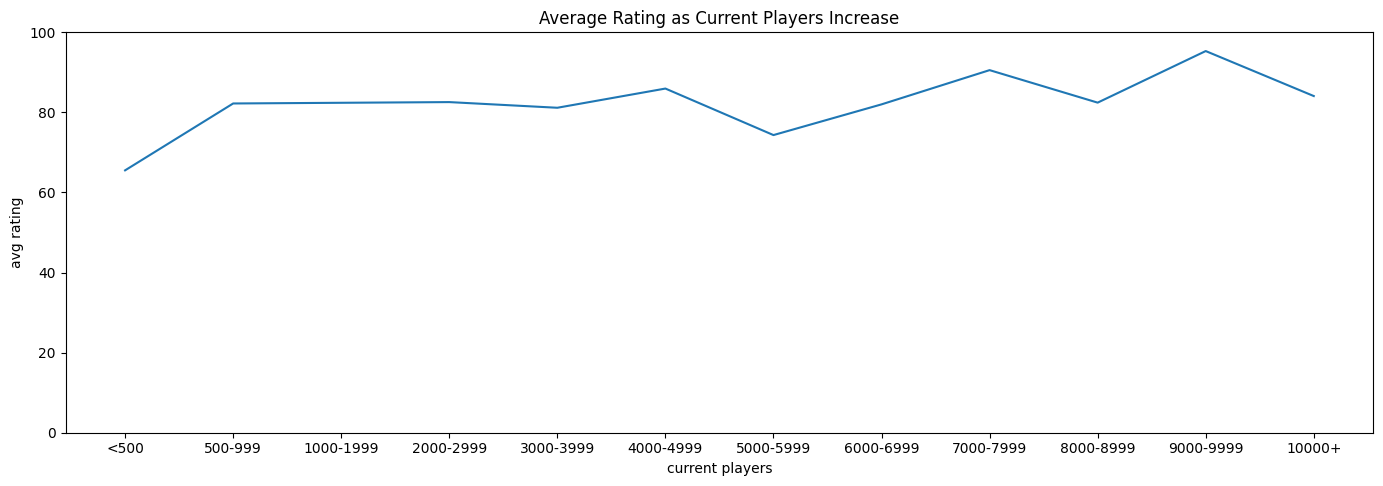

In [643]:
# make a copy of df
df_eda_7 = df_cleaned.copy()

# get current players group
current_players = []
for i in df_eda_7['players_right_now']:
    if i < 500:
        current_players.append('<500')
    elif i < 1000:
        current_players.append('500-999')
    elif i < 2000:
        current_players.append('1000-1999')
    elif i < 3000:
        current_players.append('2000-2999')
    elif i < 4000:
        current_players.append('3000-3999')
    elif i < 5000:
        current_players.append('4000-4999')
    elif i < 6000:
        current_players.append('5000-5999')
    elif i < 7000:
        current_players.append('6000-6999')
    elif i < 8000:
        current_players.append('7000-7999')
    elif i < 9000:
        current_players.append('8000-8999')
    elif i < 10_000:
        current_players.append('9000-9999')
    else:
        current_players.append('10000+')

# add current_players to df
df_eda_7['current_players'] = current_players

# group by current_players and avg rating
df_eda_7_grouped = df_eda_7.groupby(by='current_players', as_index=False)[['rating', 'players_right_now']].mean().sort_values('players_right_now')
df_eda_7_grouped.drop(columns='players_right_now', inplace=True)

# sort by estimated_total_players
# df_eda_7.sort_values(by='players_right_now', ascending=True, inplace=True)

# draw plot
x = df_eda_7_grouped['current_players']
y = df_eda_7_grouped['rating']
plt.plot(x, y)

# set plot formatting
plt.title('Average Rating as Current Players Increase')

plt.xlabel('current players')
plt.ylabel('avg rating')

plt.tight_layout()

plt.ylim(0, 100)

plt.gcf().set_size_inches([15, 5])

# show plot
plt.show()

# **5. Feature Engineering**

## **5.1. Feature Splitting**

- We split our data into features and target, with the ratio of `75 train : 25 test`
- Then we split our data into features and target for training and test purposes

In [644]:
# split X and y
X = df_cleaned.drop(columns=['rating'])
y = df_cleaned['rating']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

## **5.2. Outlier Handling**

### 5.2.1. Numeric Columns Splitting

- Split numeric columns based on their skewness into 3 categories,
    - `normally distributed` columns
    - `moderately skewed` columns
    - `highly skewed` columns

In [645]:
# make a copy of X_train & X_test
X_train_capped = X_train.copy()
X_test_capped = X_test.copy()

In [646]:
# take only the numeric columns
numeric_columns = list(X_train_capped.select_dtypes(include=np.number).columns)

# normally distributed columns containers
normal_numeric_columns = []
normal_numeric_data = []

# moderately skewed columns containers
skewed_mod_numeric_columns = []
skewed_mod_numeric_data = []

# highly skewed columns containers
skewed_high_numeric_columns = []
skewed_high_numeric_data = []

for column in numeric_columns:
    skewness = X_train_capped[column].skew()
    # if normally distributed
    if skewness <= 0.5 and skewness >= -0.5:
        normal_numeric_columns.append(column)
        normal_numeric_data.append([column, skewness])
    # if moderately skewed
    elif skewness < 1 and skewness > -1:
        skewed_mod_numeric_columns.append(column)
        skewed_mod_numeric_data.append([column, skewness])
    # if highly skewed
    else:
        skewed_high_numeric_columns.append(column)
        skewed_high_numeric_data.append([column, skewness])

# display how the columns are split
print('columns with normally distributed data: ')
display(pd.DataFrame(data=normal_numeric_data, columns=['normal_distributed_columns', 'skewness']))

print('columns with moderately skewed data: ')
display(pd.DataFrame(data=skewed_mod_numeric_data, columns=['moderately_skewed_columns', 'skewness']))

print('columns with highly skewed data: ')
display(pd.DataFrame(data=skewed_high_numeric_data, columns=['highly_skewed_columns', 'skewness']))

columns with normally distributed data: 


,normal_distributed_columns,skewness


columns with moderately skewed data: 


,moderately_skewed_columns,skewness


columns with highly skewed data: 


,highly_skewed_columns,skewness
0,peak_players,52.257754
1,positive_reviews,147.114199
2,negative_reviews,141.378912
3,total_reviews,148.770905
4,review_percentage,-1.000452
5,players_right_now,165.125586
6,24_hour_peak,168.180165
7,all_time_peak,58.414772
8,original_price,136.965302


### 5.2.2. Data Distribution Capping

**Columns with Low Variation Handling**
- To avoid an error caused by the inability of getting the `iqr` value of numeric columns with `low variation`, we'll move these columns below to the `normally distributed` category, where their outliers with be capped using the `gaussian` method

In [647]:
# move columns with low variation to the normally distributed category
low_var_columns = ['players_right_now']

for column in low_var_columns:
    # remove from original category
    skewed_high_numeric_columns.remove(column)

    # add to new category
    normal_numeric_columns.append(column)

**Reason for Capping**
- The reason that we decided to handle our outliers by capping instead of trimming is to preserve our rows' count

**Capping Model Definition and Training**
- Define capping models for each category, different categories require different methods and folds
- Train our capping models with our train set
- Update our train and test set using the models that we just defined and trained

In [648]:
# capping model definition for each numeric columns' category
# winsorizer_normal = Winsorizer(capping_method='gaussian', tail='both', fold=3,                -- no normally distributed feature
#                                variables=normal_numeric_columns, missing_values='ignore')
# winsorizer_skewed_mod = Winsorizer(capping_method='iqr', tail='both', fold=1.5,               -- no moderately skewed feature
#                                variables=skewed_mod_numeric_columns, missing_values='ignore')
winsorizer_skewed_high = Winsorizer(capping_method='iqr', tail='both', fold=3, 
                               variables=skewed_high_numeric_columns, missing_values='ignore')

# fit & tranform X_train
# X_train_capped = winsorizer_normal.fit_transform(X_train)         -- no normally distributed feature
# X_train_capped = winsorizer_skewed_mod.fit_transform(X_train)     -- no moderately skewed feature
X_train_capped = winsorizer_skewed_high.fit_transform(X_train)

# transform X_test
# X_test_capped = winsorizer_normal.transform(X_test)           -- no normally distributed feature
# X_test_capped = winsorizer_skewed_mod.transform(X_test)       -- no moderately skewed feature
X_test_capped = winsorizer_skewed_high.transform(X_test)

### **5.2.3. Visualizing Before and After Outlier Handling Function**

Due to the large number of columns to be plotted, we created a function named `outlier_handling_plot_comparison` which takes three parameters:

- `df_before`: Pandas DataFrame containing data before outlier handling.
- `df_after`: Pandas DataFrame containing data after outlier handling.
- `variable`: A string representing the name of the variable/column to be plotted.

This function will create Histogram and Boxplot visualizations before and after outlier handling for all numeric columns.
I will demonstrate its usage with examples in the function's docstring in the following code.

**Function Definition**

In [649]:
# plot distribution comparison
# function definition
def outlier_handling_plot_comparison(df_before, df_after, variable):
    """
    This function is created to plot histograms and boxplots for a variable before and after outlier handling
    
    Parameters:
    - df_before (pandas.DataFrame): DataFrame before outlier handling
    - df_after (pandas.DataFrame): DataFrame after outlier handling
    - variable (str): The variable to plot
    
    Example: 
    num_cols = ['numeric_column']                                   <- Enter the numeric column
    for col in num_cols:                                            <- make a for loop in numeric column to access every columns
        plot_distribution_comparison(X_train, X_train_capped, col)  <- put X_train, X_train_capped, and columns in the variable

    """
    # figure size, and super title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))                               
    fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

    # plot histogram before
    sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Histogram Before')

    # plot boxplot before
    sns.boxplot(y=df_before[variable], ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Boxplot Before')

    # plot histogram after
    sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Histogram After')

    # plot boxplot after
    sns.boxplot(y=df_after[variable], ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Using the Function**

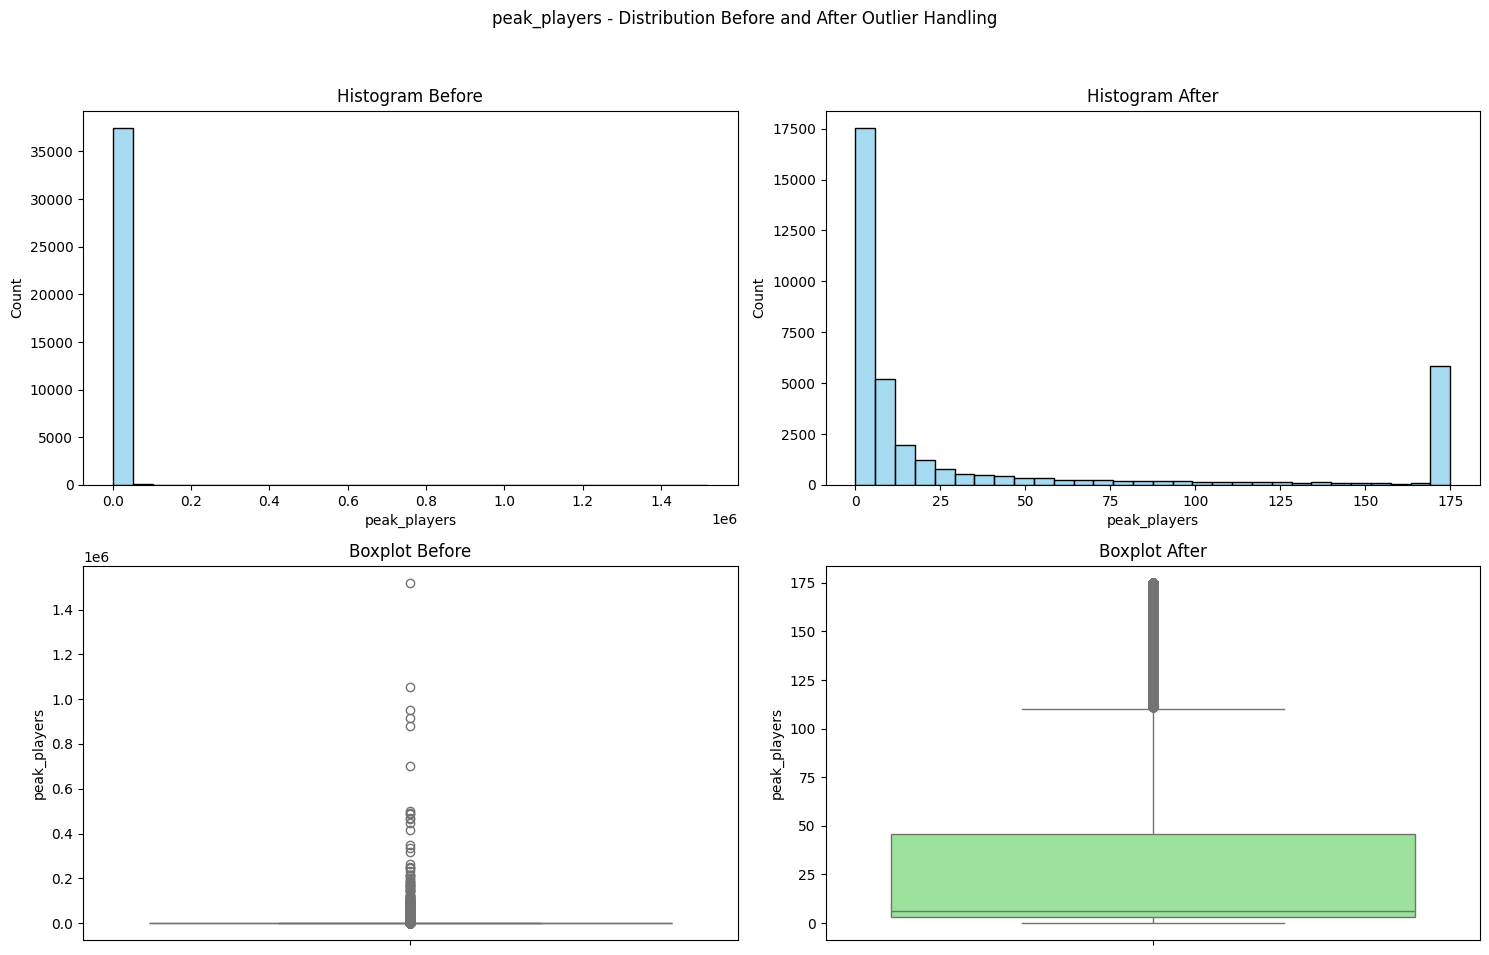

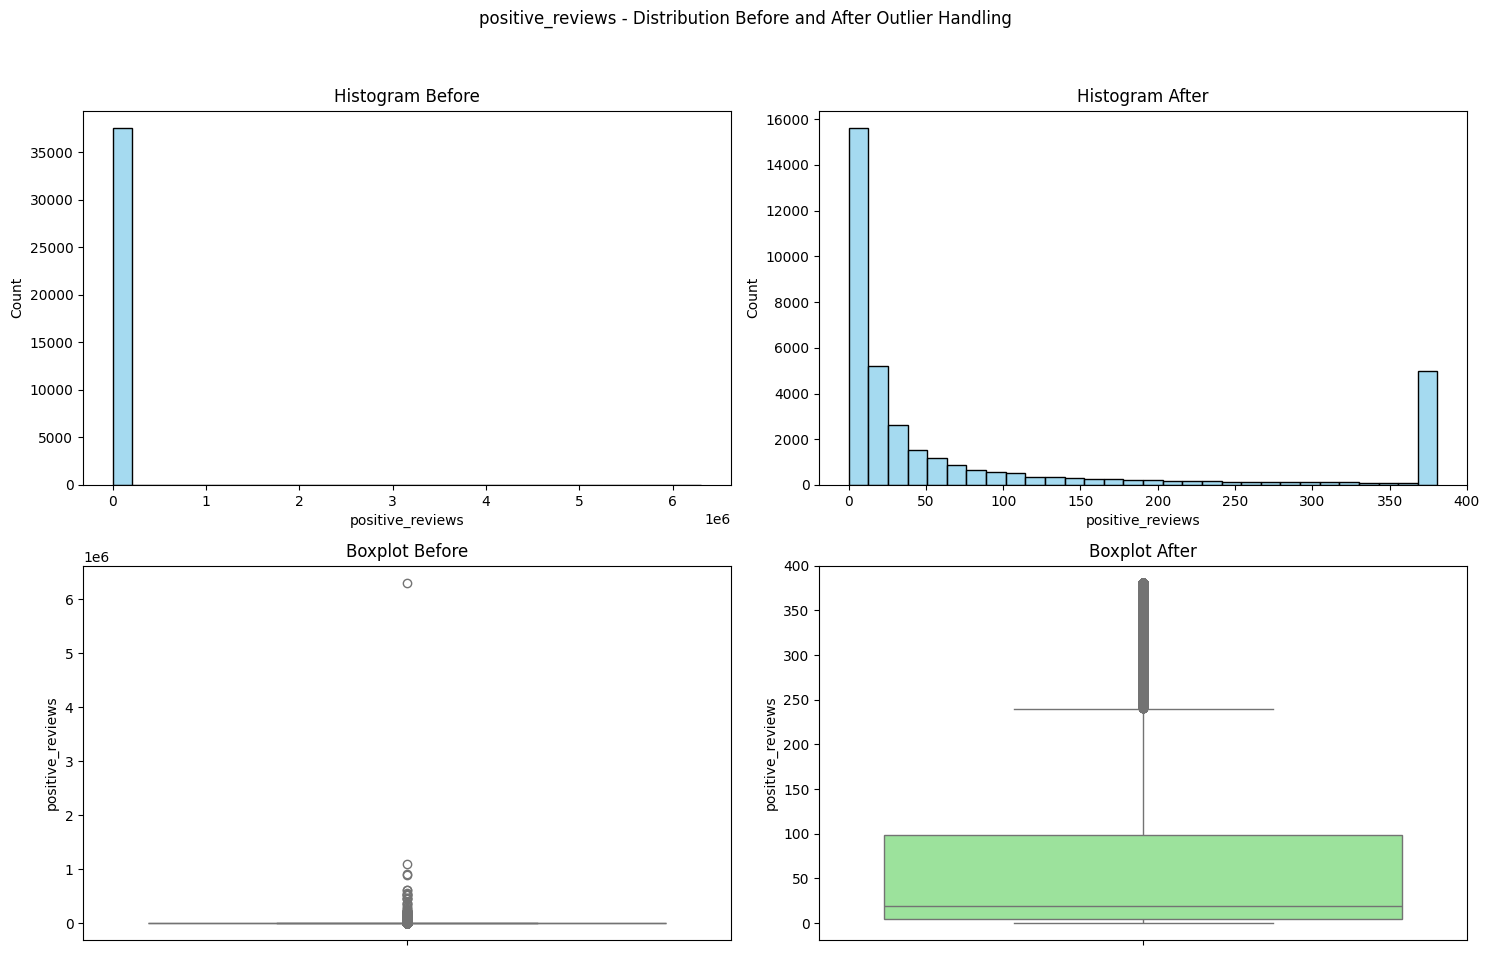

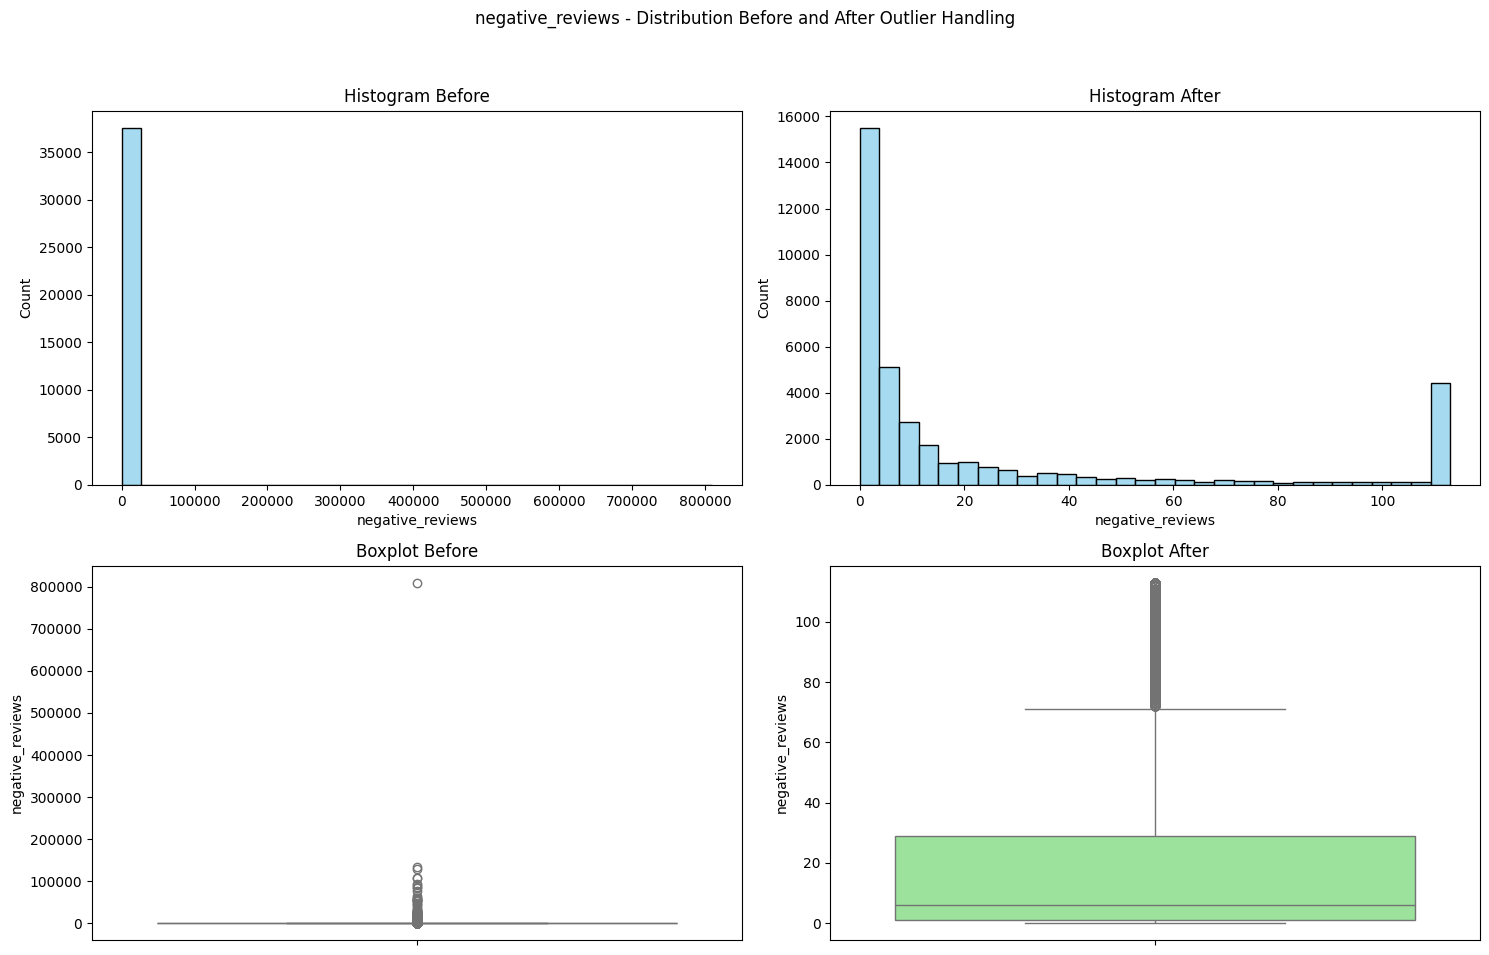

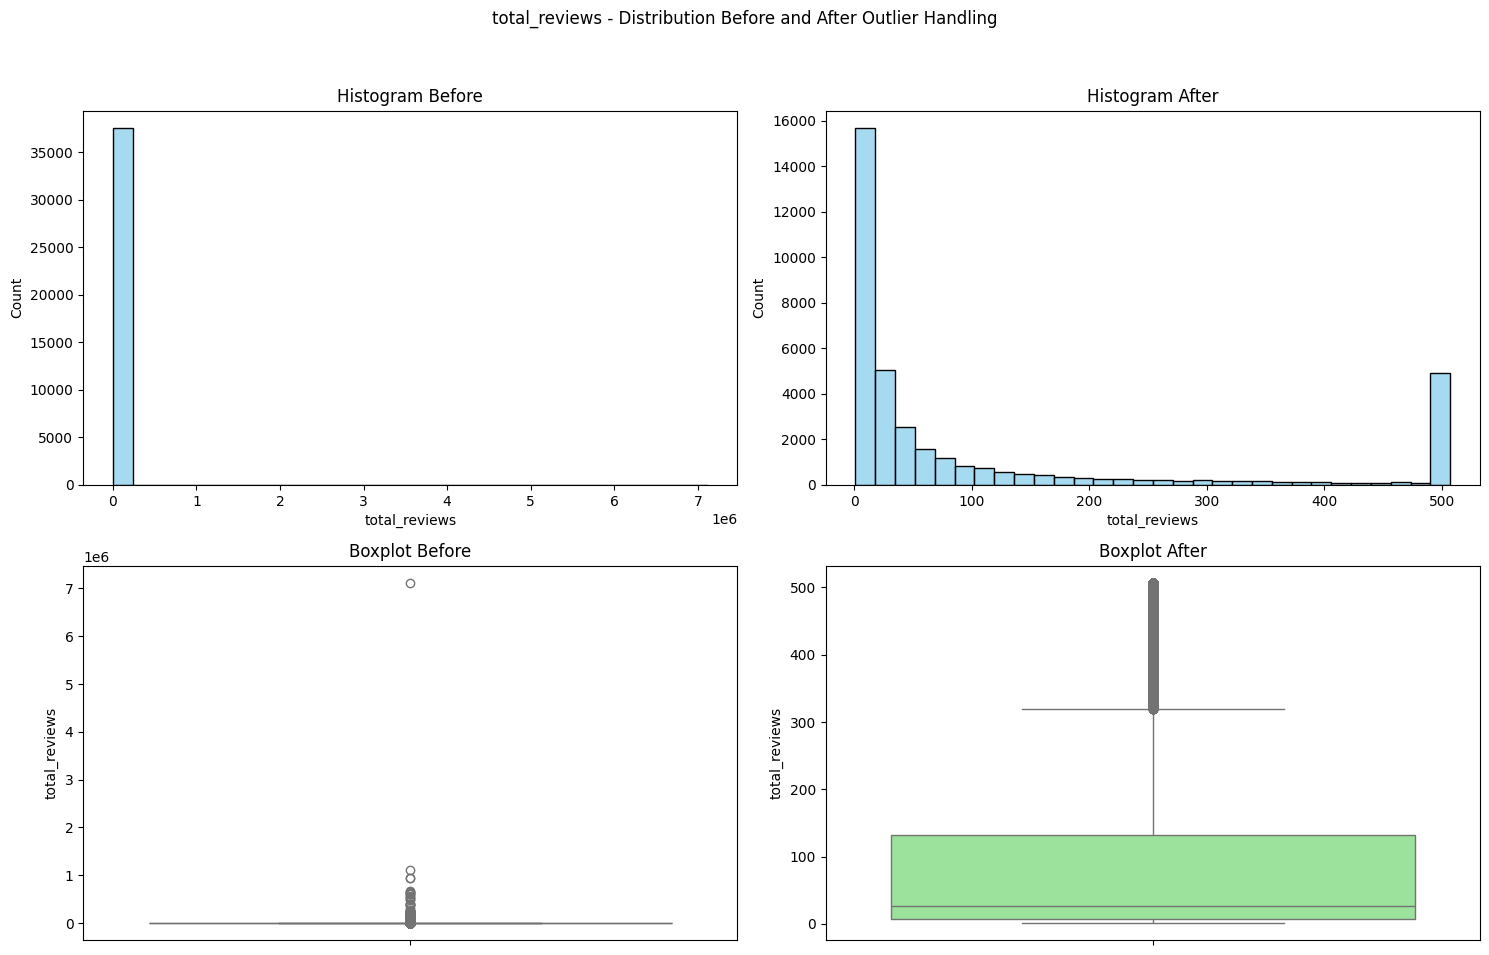

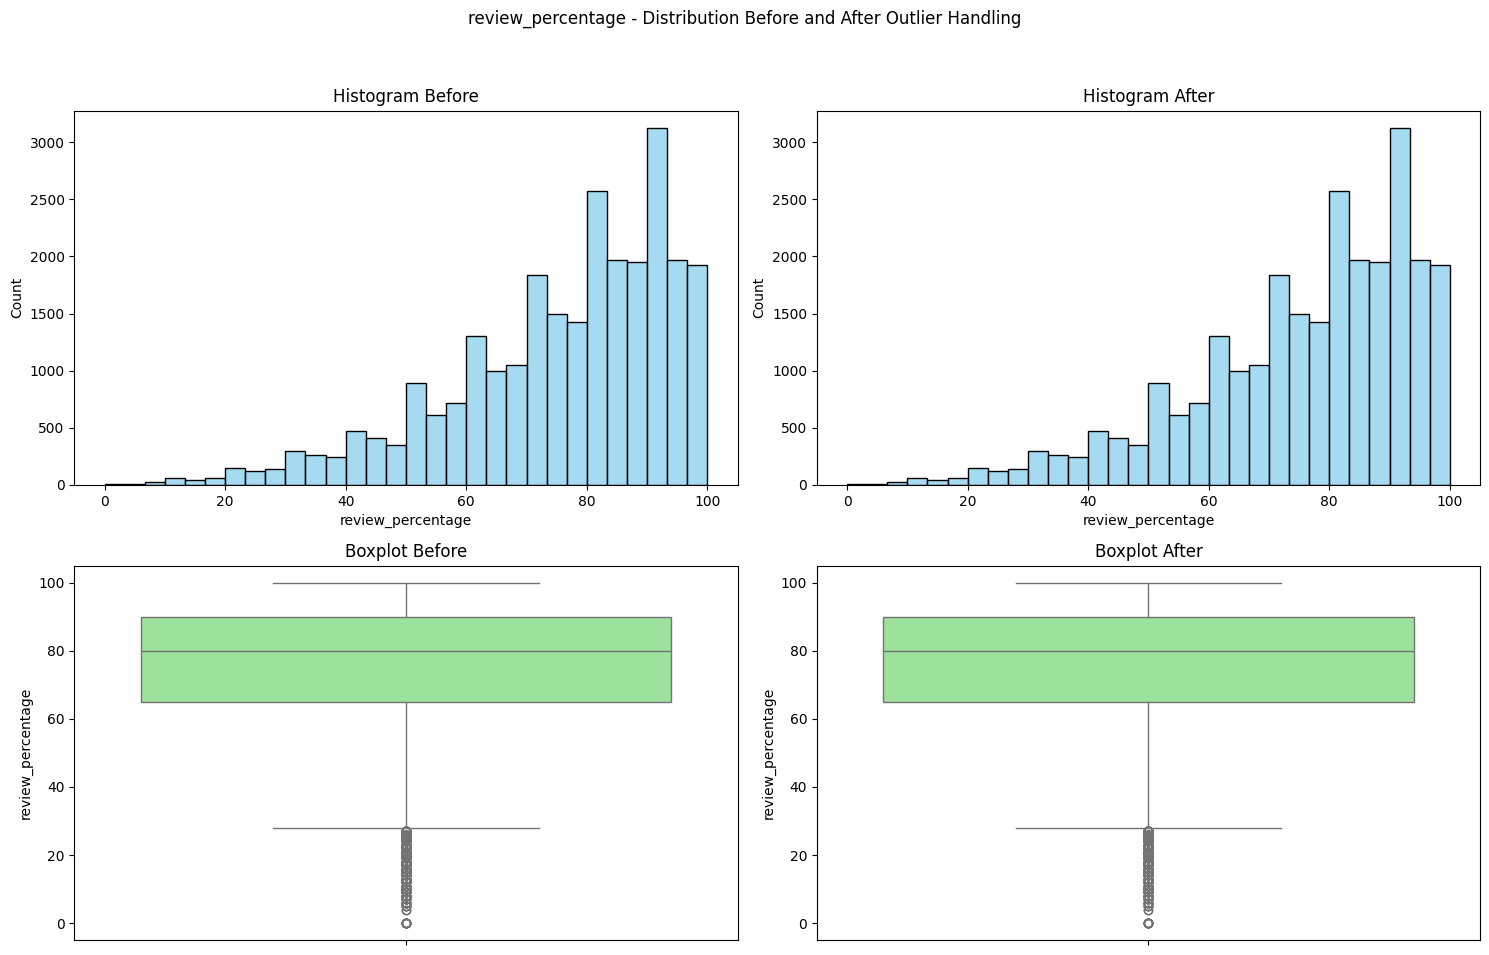

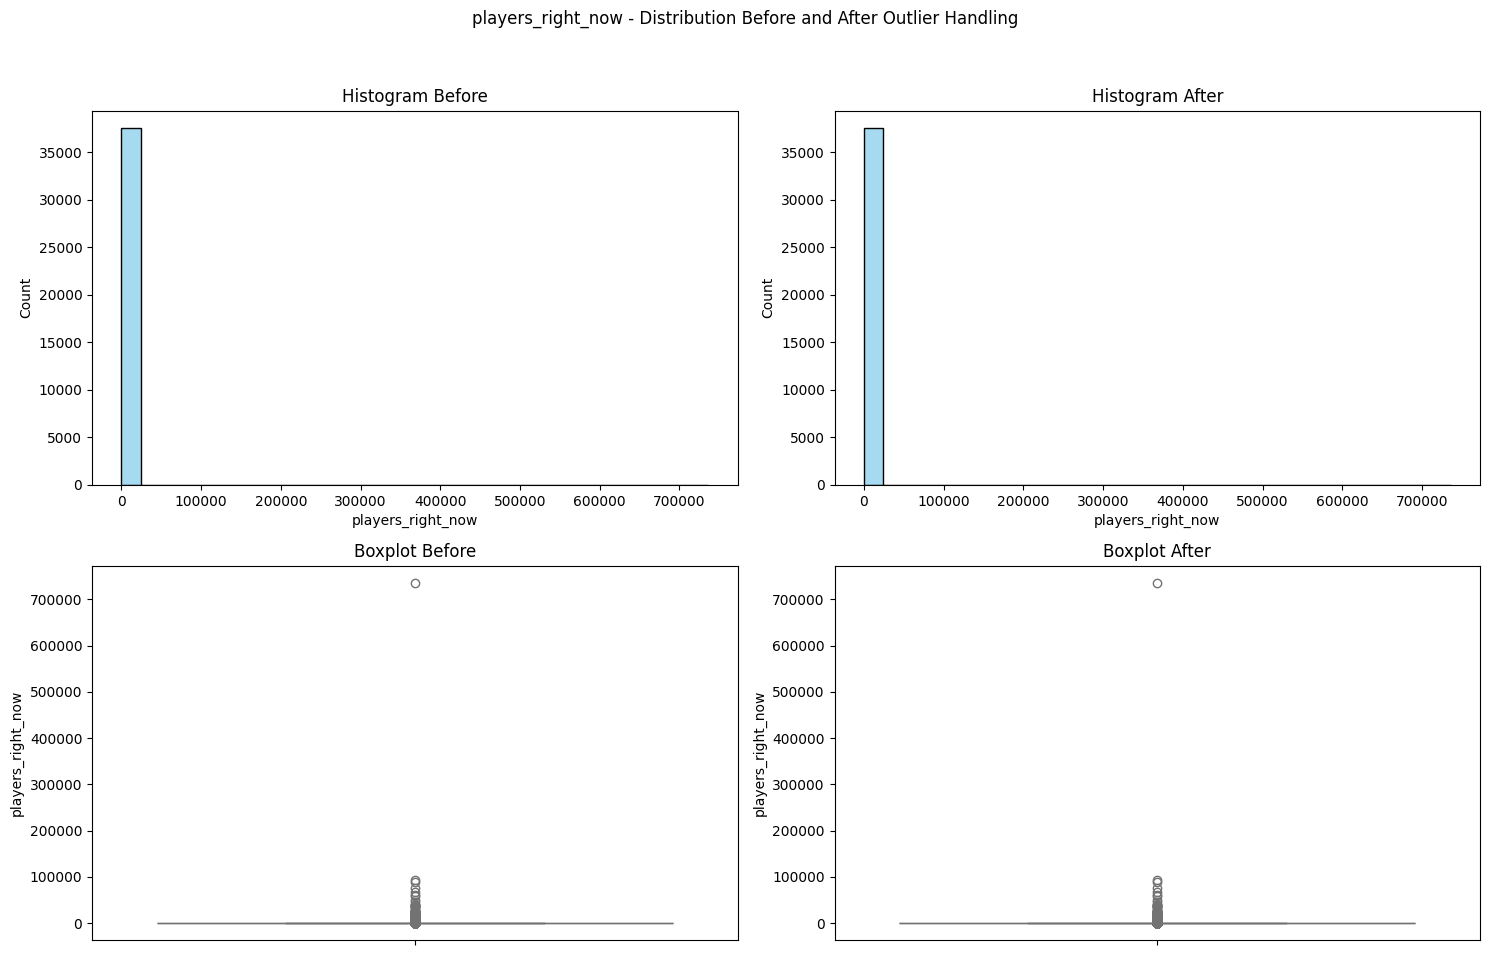

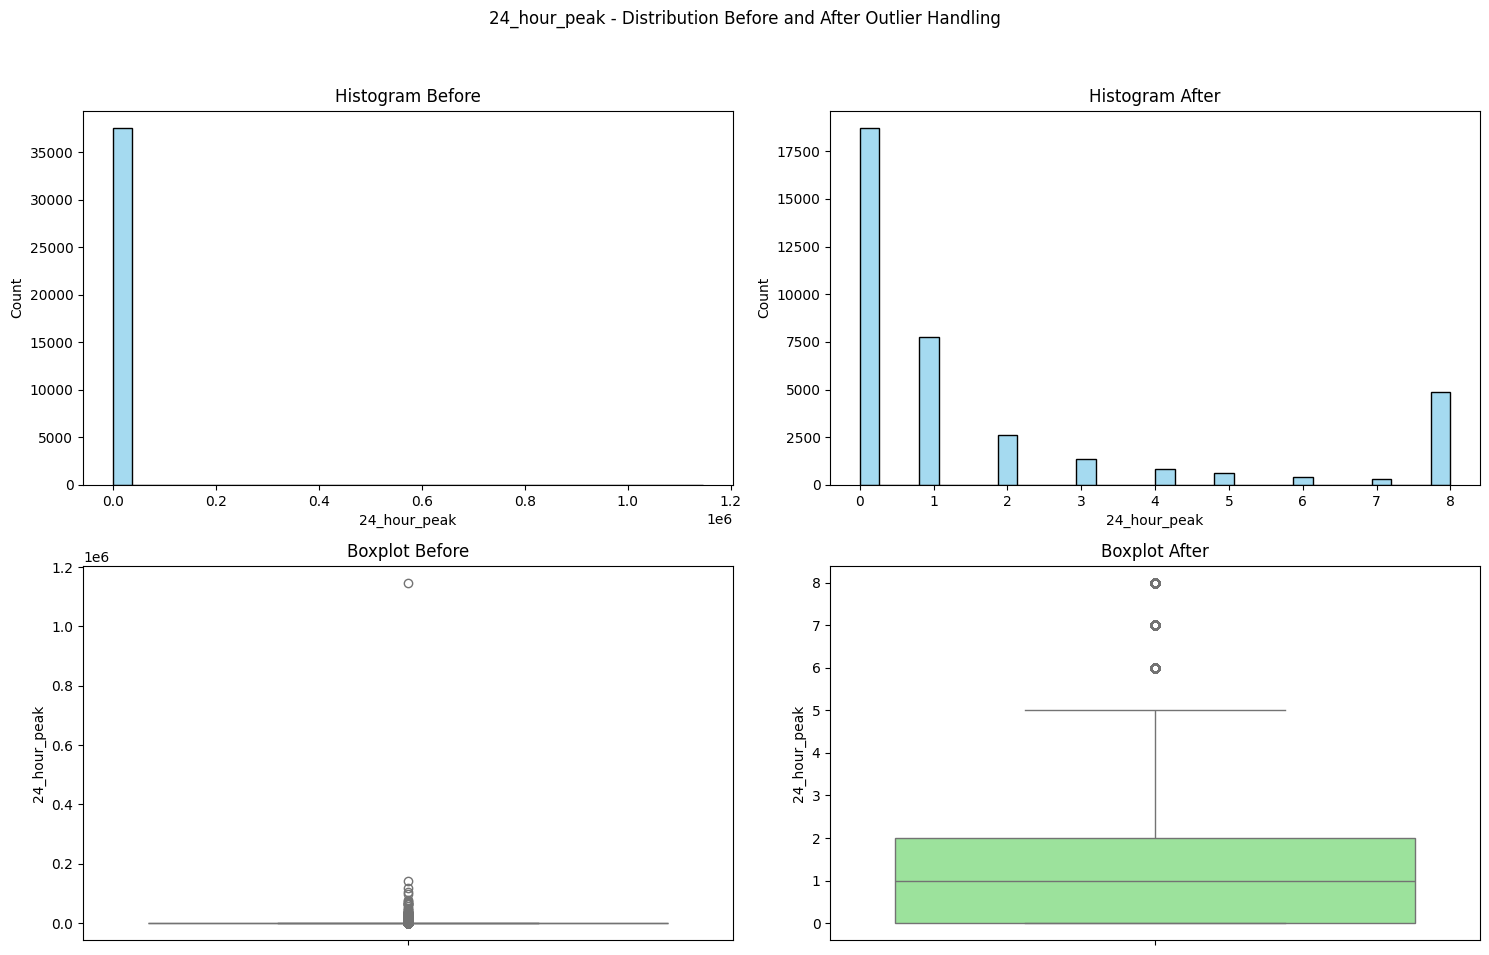

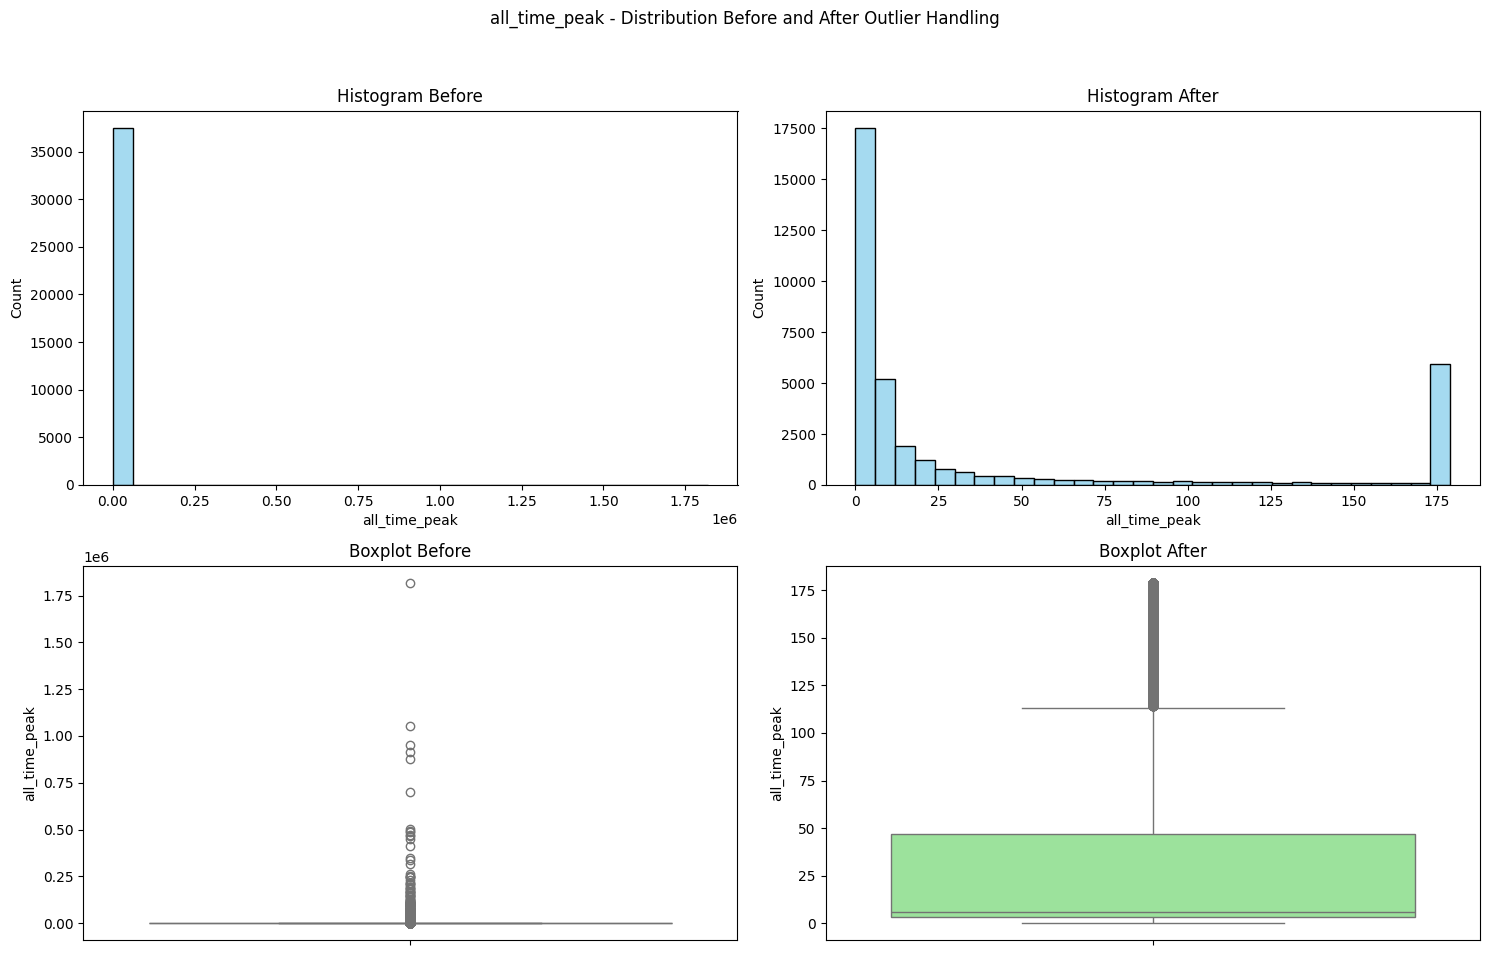

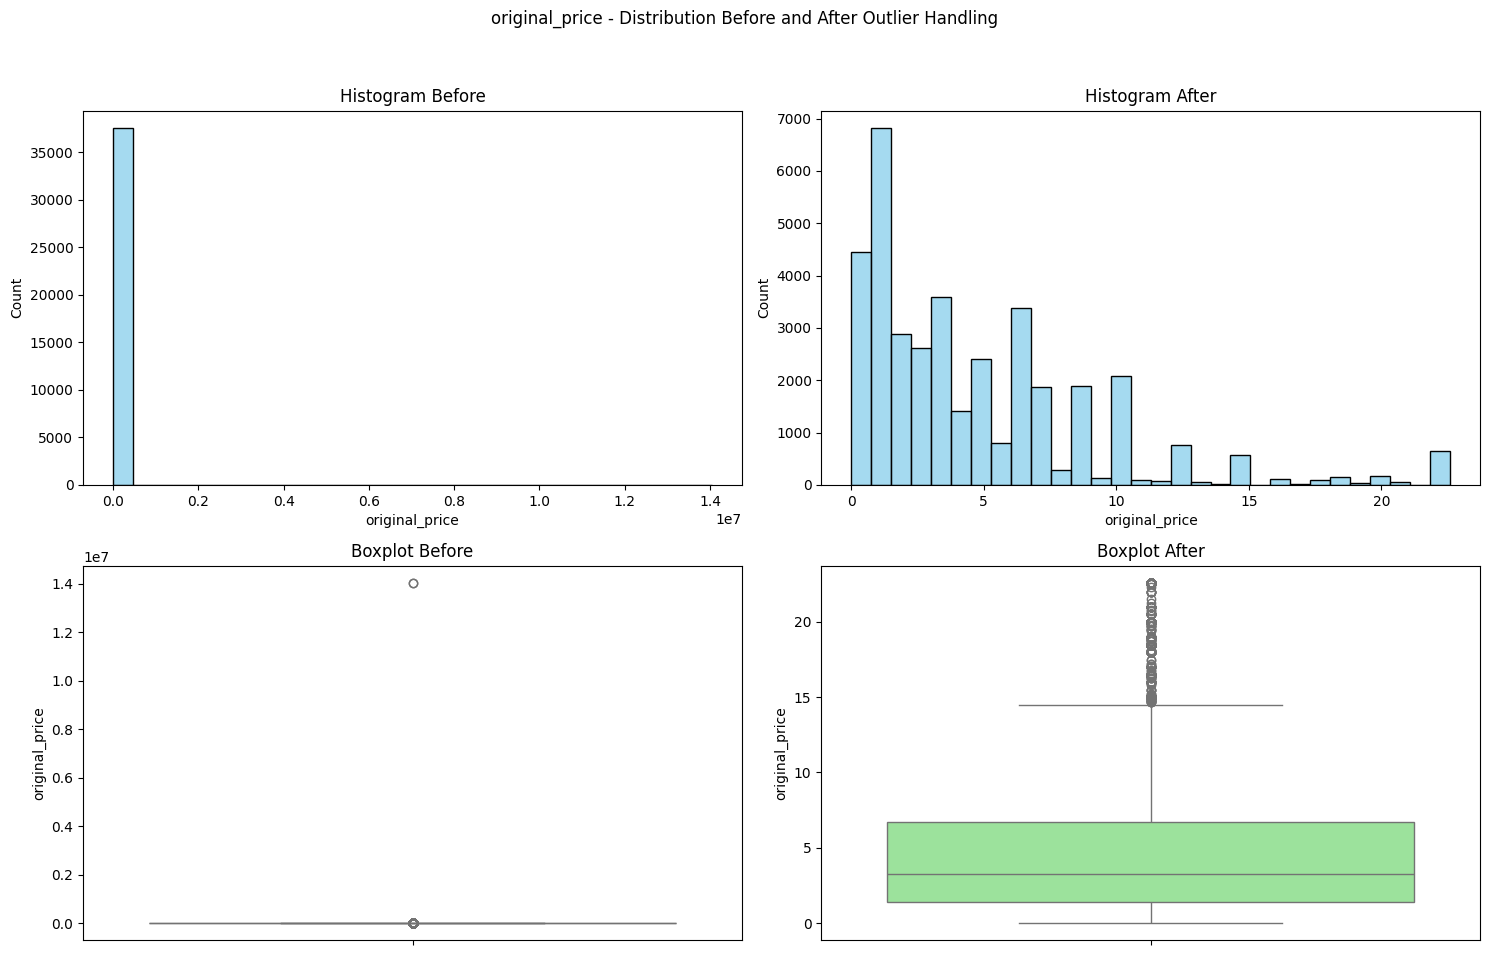

In [650]:
for col in numeric_columns:
    outlier_handling_plot_comparison(X_train, X_train_capped, col)

## **5.3. Missing Value Handling**

As we already discovered on [Basic Data Exploration](##3.2.-Basic-Data-Exploration), we have some missing values that we'll handle as such,
- Action:
    - (Will be postponed to feature engineering) impute missing values in column `primary_genre`, `publisher`, `developer`
        - because there's 'unknown' value in these columns
    - (Will be postponed to feature engineering) drop missing values in column `store_asset_mod_time`, `review_percentage`, `players_right_now`, `24_hour_peak`, `detected_technologies`
        - because we couldn't find any pattern and the correlation with other column

In [651]:
# make a copy of X_train & X_test
X_train_no_na = X_train_capped.copy()
X_test_no_na = X_test_capped.copy()

In [652]:
# data amount before trimmming
rows_amount_before_trim_data = [len(X_train_no_na), len(y_train), len(X_test_no_na), len(y_test)]

# get indexes of rows with missing values to impute
X_train_no_na['primary_genre'][X_train_no_na['primary_genre'].isnull()] = 'Unknown'
X_train_no_na['publisher'][X_train_no_na['publisher'].isnull()] = 'Unknown'
X_train_no_na['developer'][X_train_no_na['developer'].isnull()] = 'Unknown'
X_train_no_na['detected_technologies'][X_train_no_na['detected_technologies'].isnull()] = ['Unknown']

X_test_no_na['primary_genre'][X_test_no_na['primary_genre'].isnull()] = 'Unknown'
X_test_no_na['publisher'][X_test_no_na['publisher'].isnull()] = 'Unknown'
X_test_no_na['developer'][X_test_no_na['developer'].isnull()] = 'Unknown'
X_test_no_na['detected_technologies'][X_test_no_na['detected_technologies'].isnull()] = ['Unknown']

# get indexes of rows with missing values to drop
index_rows_na_train = list(X_train_no_na[(X_train_no_na['store_asset_mod_time'].isnull()) | 
                                         (X_train_no_na['review_percentage'].isnull()) |
                                         (X_train_no_na['players_right_now'].isnull()) |
                                         (X_train_no_na['24_hour_peak'].isnull())].index)
index_rows_na_test = list(X_test_no_na[(X_test_no_na['store_asset_mod_time'].isnull()) | 
                                         (X_test_no_na['review_percentage'].isnull()) |
                                         (X_test_no_na['players_right_now'].isnull()) |
                                         (X_test_no_na['24_hour_peak'].isnull())].index)

X_train_no_na.drop(axis='index', index=index_rows_na_train, inplace=True)
y_train.drop(axis='index', index=index_rows_na_train, inplace=True)
X_test_no_na.drop(axis='index', index=index_rows_na_test, inplace=True)
y_test.drop(axis='index', index=index_rows_na_test, inplace=True)

# data amount after trimming
rows_amount_after_trim_data = [len(X_train_no_na), len(y_train), len(X_test_no_na), len(y_test)]

# dropeed_rows_data
dropped_rows_data = []

for i in range(len(rows_amount_after_trim_data)):
    difference = rows_amount_before_trim_data[i] - rows_amount_after_trim_data[i]
    dropped_rows_data.append(difference)

# display the difference in data amount before and after trimming
print('missing value handling info: ')
display(pd.DataFrame({
    'dataset' : ['X_train', 'y_train', 'X_test', 'y_test'],
    'amount before trimming' : rows_amount_before_trim_data,
    'amount after trimming' : rows_amount_after_trim_data,
    'rows dropped' : dropped_rows_data
}))

missing value handling info: 


,dataset,amount before trimming,amount after trimming,rows dropped
0,X_train,37522,26493,11029
1,y_train,37522,26493,11029
2,X_test,12508,8914,3594
3,y_test,12508,8914,3594


## **5.4. Feature Selection**

- We only care about features that are `significant to our target`
- We'll eliminate features that are not that significant, until what's left are significant features 
- We'll eliminate these features in steps, according to these measurements: `cardinality`, `correlation to target`, and `inference-ability`

**Create a List of Features that we'll select from**

In [653]:
# make a copy of X_train & X_test
X_train_selected = X_train_no_na.copy()
X_test_selected = X_test_no_na.copy()

# make a list of features that we'll select from
selected_num_features = X_train_selected.select_dtypes(include='number').columns.to_list()
selected_cat_features = X_test_selected.select_dtypes(include='object').columns.to_list()

### **5.4.1. Based on Cardinality**

- We drop categorical features with `high cardinality` because `they won't help our model in recognizing patterns` (too unique/ too specific)

#### **5.4.1.1. Cardinality Check**

In [654]:
# explode list values
X_train_selected_temp = X_train_selected.copy()
X_train_selected_temp = X_train_selected_temp.explode('detected_technologies')
X_train_selected_temp = X_train_selected_temp.explode('supported_languages')
X_train_selected_temp = X_train_selected_temp.explode('popular_tags')
X_train_selected_temp = X_train_selected_temp.explode('game_features')

cat_features = X_train_selected_temp.select_dtypes(include='object').columns.to_list()

unique_value_count_data = list(X_train_selected_temp[cat_features].nunique()) 

display(pd.DataFrame({
    'column_name' : list(X_train_selected_temp[cat_features].columns),
    'unique value count' : unique_value_count_data
}))

,column_name,unique value count
0,game,25938
1,primary_genre,18
2,publisher,14017
3,developer,17016
4,detected_technologies,228
5,supported_languages,108
6,popular_tags,443
7,game_features,36


#### **5.4.1.2. Drop High Cardinality Features**

- The feature that we'll drop due to high cardinality are `game`, `publisher`, `developer`
- Features with datetime data type will be automatically dropped due to high cardinality

In [655]:
# drop features with high cardinality
high_card_features = ['game', 'publisher', 'developer', 'release', 'store_asset_mod_time', 'all_time_peak_date']
print(f'feature(s) with high cardinality dropped: {high_card_features}')

for feature in high_card_features:
    if feature in selected_num_features:
        selected_num_features.remove(feature)
    elif feature in selected_cat_features:
        selected_cat_features.remove(feature)

X_train_selected.drop(columns=high_card_features, inplace=True)
X_test_selected.drop(columns=high_card_features, inplace=True)

feature(s) with high cardinality dropped: ['game', 'publisher', 'developer', 'release', 'store_asset_mod_time', 'all_time_peak_date']


### **5.4.2. Based on Correlation**

- We only take features with significant correlation to our target because having `too many insignificant features` would `make our prediction worse`

#### **5.4.2.1. Numeric Features' Correlation to `target`**

In [656]:
# data containers
column_names = []
corrs = []
p_values = []
interpretations = []
no_corr_features = []

num_features = X_train_selected.select_dtypes(include='number').columns.values

for feature in num_features:
    # for normally distributed features
    if abs(X_train_selected[feature].skew()) < 0.5: 
        corr_coef, p_value = pearsonr(X_train_selected[feature], y_train)

        column_names.append(feature)
        corrs.append(corr_coef)
        p_values.append(p_value)

        # if significantly correlated
        if p_value < 0.05: 
            interpretations.append('Significant Correlation')
        # if not significantly correlated
        else :
            interpretations.append('No Significant Correlation')
            no_corr_features.append(feature)

    # for skewed features
    else:
        corr_coef, p_value = spearmanr(X_train_selected[feature], y_train)

        column_names.append(feature)
        corrs.append(corr_coef)
        p_values.append(p_value)

        # if significantly correlated
        if p_value < 0.05: 
            interpretations.append('Significant Correlation')
        # if not significantly correlated
        else :
            interpretations.append('No Significant Correlation')
            no_corr_features.append(feature)

# display result
display(pd.DataFrame({
    'column_names' : column_names,
    'correlation_coefficient' : corrs,
    'p_value' : p_values,
    "interpretation" : interpretations
}))

,column_names,correlation_coefficient,p_value,interpretation
0,peak_players,0.312853,0.000000e+00,Significant Correlation
1,positive_reviews,0.563818,0.000000e+00,Significant Correlation
2,negative_reviews,-0.013791,2.478535e-02,Significant Correlation
3,total_reviews,0.425350,0.000000e+00,Significant Correlation
4,review_percentage,0.911349,0.000000e+00,Significant Correlation
5,players_right_now,0.361779,0.000000e+00,Significant Correlation
6,24_hour_peak,0.413319,0.000000e+00,Significant Correlation
7,all_time_peak,0.299499,0.000000e+00,Significant Correlation
8,original_price,0.159900,3.127546e-151,Significant Correlation


#### **5.4.2.2. Categorical Features' Correlation to `target`**

In [657]:
# data containers
column_names = []
corrs = []
p_values = []
interpretations = []

cat_features = list(X_train_selected.select_dtypes(include='object').columns)

# remove list value columns
to_remove = ['detected_technologies', 'supported_languages', 'popular_tags', 'game_features']
for i in to_remove:
    cat_features.remove(i)

for feature in cat_features:
    corr_coef, p_value = kendalltau(X_train_selected[feature], y_train)

    column_names.append(feature)
    corrs.append(corr_coef)
    p_values.append(p_value)

    # if significantly correlated
    if p_value < 0.05: 
        interpretations.append('Significant Correlation')
    # if not significantly correlated
    else :
        interpretations.append('No Significant Correlation')
        no_corr_features.append(feature)

# display result
display(pd.DataFrame({
    'column_names' : column_names,
    'correlation_coefficient' : corrs,
    'p_value' : p_values,
    "interpretation" : interpretations
}))

,column_names,correlation_coefficient,p_value,interpretation
0,primary_genre,-0.024328,3.065607e-08,Significant Correlation


#### **5.4.2.3. Drop Features with No Significant Correlation:**
- There is no feature that we'll drop due to the lack of significant correlation

In [658]:
# drop features with no significant correlation
print(f'feature(s) with no significant correlation dropped: {no_corr_features}')

for feature in no_corr_features:
    if feature in selected_num_features:
        selected_num_features.remove(feature)
    else:
        selected_cat_features.remove(feature)

X_train_selected.drop(columns=no_corr_features, inplace=True)
X_test_selected.drop(columns=no_corr_features, inplace=True)

feature(s) with no significant correlation dropped: []


### **5.4.3. Based on Collinearity**

#### **5.4.3.1. Check Features' Collinearity**

- We don't take features with high collinearity because their `influence is influenced by other feature` (the more `'independent'` our feature is the better)
- As per statsmodels' recommendation: 
    - "One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.", [source](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)
- We'll see how collinear our features are by observing their vif score

In [659]:
# vif data container
vifs = []
high_coll_features = []

num_features = X_train_selected.select_dtypes(include='number').columns.values

for i in range(len(num_features)):
    vif = variance_inflation_factor(X_train_selected[num_features].values, i)
    vifs.append(vif) 
    if vif > 5:
        high_coll_features.append(num_features[i])

# show selected features' vif
display(pd.DataFrame({
    'numeric_feature' : num_features,
    'vif' : vifs
}))

,numeric_feature,vif
0,peak_players,44.925872
1,positive_reviews,171.252685
2,negative_reviews,17.847516
3,total_reviews,247.082389
4,review_percentage,2.572403
5,players_right_now,1.003679
6,24_hour_peak,4.399646
7,all_time_peak,42.842135
8,original_price,2.355965


#### **5.4.3.2. Drop Features with high collinearity**

- The features that we'll drop due to high collinearity are `peak_players`, `positive_reviews`, `negative_reviews`, `total_reviews`, `all_time_peak`

In [660]:
# drop features with high collinearity
print(f'feature(s) with high collinearity to drop: {high_coll_features}')

for feature in high_coll_features:
    if feature in selected_num_features:
        selected_num_features.remove(feature)
    else:
        selected_cat_features.remove(feature)

X_train_selected.drop(columns=high_coll_features, inplace=True)
X_test_selected.drop(columns=high_coll_features, inplace=True)

feature(s) with high collinearity to drop: ['peak_players', 'positive_reviews', 'negative_reviews', 'total_reviews', 'all_time_peak']


### **5.4.3. Based on Inference-Ability**

- Because we want to create a prediction model, where we will be able to input some variables that our model will predict from, we will drop features that we won't be able to input, since we won't know what their values are
- The features that we'll drop due to the lack of inference-ability are `review_percentage`, `detected_technologies`, `supported_languages`, `popular_tags`, `game_features`

In [661]:
# drop features with lacking inference-ability
inf_inability_features = ['review_percentage', 'detected_technologies', 'supported_languages',
                          'popular_tags', 'game_features']
print(f'feature(s) with no inference ability dropped: {inf_inability_features}')

for feature in inf_inability_features:
    if feature in selected_num_features:
        selected_num_features.remove(feature)
    elif feature in selected_cat_features:
        selected_cat_features.remove(feature)

X_train_selected.drop(columns=inf_inability_features, inplace=True)
X_test_selected.drop(columns=inf_inability_features, inplace=True)

feature(s) with no inference ability dropped: ['review_percentage', 'detected_technologies', 'supported_languages', 'popular_tags', 'game_features']


### **5.4.4. Final Selected Features**

- After evaluating our features based on each of their cardinality, correlation to our target, and collinearity, the features that we selected are, 

In [662]:
display(X_train_selected.head())
display(X_test_selected.head())

,primary_genre,players_right_now,24_hour_peak,original_price
21452,Action,0.0,1.0,10.49
12600,Action,0.0,8.0,0.00
35413,Action,0.0,1.0,0.00
22733,Casual,0.0,1.0,3.29
21207,Indie,0.0,0.0,1.39


,primary_genre,players_right_now,24_hour_peak,original_price
23880,Sports,0.0,2.0,12.49
41302,Adventure,53.0,8.0,12.49
9793,Simulation,10.0,8.0,22.59
35199,Indie,0.0,0.0,1.39
37498,Adventure,1.0,8.0,19.99


## **5.5. Feature Scaling**

- Because the `range` of our numeric features are quite `different`, we scale these numeric features to `avoid bias` in influence to our prediction
- The scaling method that we use is `RobustScaler` because even after we handle our outliers, we still have a lot of them on some highly skewed features

In [663]:
# make a copy of X_train & X_test
X_train_scaled = X_train_selected.copy()
X_test_scaled = X_test_selected.copy()

In [664]:
# scaler model definition
scaler = RobustScaler()

scaler

RobustScaler()

## **5.6. Feature Encoding**

- Our prediction models, `KNN`, `SVM`, `Decision Tree` and `Random Forest` only takes `numbers` as its features/independent values, so we'll turn our `categorical features to their numerical form` through a process called `encoding` 
- Because all of our categorical features are nominal variables, we'll use,
    - `OneHotEncoder` for regular categorical features
    - `MultiLabelBinarizer` for list categorical features (multiple values per cell)- Because there are columns with multiple values in a cell, we'll use 
- MultiLabel will be excluded from column transformer pipeline, because it can't be used in a column transformer [source](https://github.com/scikit-learn/scikit-learn/issues/11309)

In [665]:
# make a copy of X_train & X_test
X_train_encoded = X_train_scaled.copy()
X_test_encoded = X_test_scaled.copy()

In [666]:
# encoder model definition
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## **5.7. Final Features**

- Here's a recap on the steps that we took to process our features:
    - `Split` -> `handle outlier` -> `handle missing value` -> `select` -> `scale` -> `encode`
- We end up with our final features as displayed below

In [667]:
# final X_train(s) declaration
X_train_final = X_train_encoded.copy()
X_test_final = X_test_encoded.copy()

print('final train set: ')
display(X_train_final.head())
print('final test set: ')
display(X_test_final.head())

final train set: 


,primary_genre,players_right_now,24_hour_peak,original_price
21452,Action,0.0,1.0,10.49
12600,Action,0.0,8.0,0.00
35413,Action,0.0,1.0,0.00
22733,Casual,0.0,1.0,3.29
21207,Indie,0.0,0.0,1.39


final test set: 


,primary_genre,players_right_now,24_hour_peak,original_price
23880,Sports,0.0,2.0,12.49
41302,Adventure,53.0,8.0,12.49
9793,Simulation,10.0,8.0,22.59
35199,Indie,0.0,0.0,1.39
37498,Adventure,1.0,8.0,19.99


# **6. Model Definition**

## **6.1.Column Transformer Definition**

In [668]:
# Defining Column Transformer
transformer = ColumnTransformer([
    ('scaler', scaler, selected_num_features),
    ('encoder', encoder, selected_cat_features)
], remainder='drop'
)

transformer

ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                 ['players_right_now', '24_hour_peak',
                                  'original_price']),
                                ('encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['primary_genre'])])

## **6.2. Regressors Definition**

- There are 5 regressor models that we'll use, which are: `KNN`, `SVM`, `Decision Treee`, `Random Forest`, and `AdaBoost`. We'll define, train, predict, then evaluate all these models before we then proceed onto the next step
- **Hyperparameters:**
    - The hyperparameters for `KNN` is `n_neighbors`
    - The hyperparameters for `SVM` are `C`, `gamma`
    - The hyperparameters for `Decision Tree` are `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`
    - The hyperparameters for `Random Forest` are `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`
    - The hyperparameters for `AdaBoost` are `n_estimators`, `learning_rate`
- **Metrics:**
    - To evaluate our model we'll use these metrics,
        - MAE to give us an idea of the absolute error of our prediction
        - MAPE to give us an idea of the percentage of absolute error of our prediction
        - r-squared to give us an idea of how well our features explain the variance of our prediction

**KNN**

In [669]:
knn = KNeighborsRegressor()

knn_pipe = Pipeline([
    ('transformer', transformer),
    ('knn', knn)
])

knn_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('knn', KNeighborsRegressor())])

**SVM**

In [670]:
svm = SVR()

svm_pipe = Pipeline([
    ('transformer', transformer),
    ('svm', svm)
])

svm_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('svm', SVR())])

**Decision Tree**

In [671]:
dt = DecisionTreeRegressor()

dt_pipe = Pipeline([
    ('transformer', transformer),
    ('dt', dt)
])

dt_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('dt', DecisionTreeRegressor())])

**Random Forest**

In [672]:
rf = RandomForestRegressor()

rf_pipe = Pipeline([
    ('transformer', transformer),
    ('rf', rf)
])

rf_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('rf', RandomForestRegressor())])

**AdaBoost**

In [673]:
ab = AdaBoostRegressor()

ab_pipe = Pipeline([
    ('transformer', transformer),
    ('ab', ab)
])

ab_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('ab', AdaBoostRegressor())])

# **7. Model Training**

- We train our `base models` with our features and targets that we had split for training purpose earlier

**KNN**

In [674]:
knn_pipe.fit(X_train_final, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('knn', KNeighborsRegressor())])

**SVM**

In [675]:
svm_pipe.fit(X_train_final, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('svm', SVR())])

**Decision Tree**

In [676]:
dt_pipe.fit(X_train_final, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('dt', DecisionTreeRegressor())])

**Random Forest**

In [677]:
rf_pipe.fit(X_train_final, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('rf', RandomForestRegressor())])

**AdaBoost**

In [678]:
ab_pipe.fit(X_train_final, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['players_right_now',
                                                   '24_hour_peak',
                                                   'original_price']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['primary_genre'])])),
                ('ab', AdaBoostRegressor())])

# **8. Model Evaluation**

## **8.1. Get Base Models Predictions**

In [679]:
y_pred_knn_train = knn_pipe.predict(X_train_final)
y_pred_knn_test = knn_pipe.predict(X_test_final)

y_pred_svm_train = svm_pipe.predict(X_train_final)
y_pred_svm_test = svm_pipe.predict(X_test_final)

y_pred_dt_train = dt_pipe.predict(X_train_final)
y_pred_dt_test = dt_pipe.predict(X_test_final)

y_pred_rf_train = rf_pipe.predict(X_train_final)
y_pred_rf_test = rf_pipe.predict(X_test_final)

y_pred_ab_train = ab_pipe.predict(X_train_final)
y_pred_ab_test = ab_pipe.predict(X_test_final)

## **8.2. Evaluate Base Models**

- **Metrics:**
    - To evaluate our model we'll use these metrics,
        - MAE to give us an idea of the absolute error of our prediction
        - MAPE to give us an idea of the percentage of absolute error of our prediction
        - r-squared to give us an idea of how well our features explain the variance of our prediction

In [680]:
# evaluate using metrics mae, mape, r2
pred_results_train = [y_pred_knn_train, y_pred_svm_train, y_pred_dt_train, y_pred_rf_train, y_pred_ab_train]
pred_results_test = [y_pred_knn_test, y_pred_svm_test, y_pred_dt_test, y_pred_rf_test, y_pred_ab_test]
mae_train = []
mape_train = []
r2_train = []
mae_test = []
mape_test = []
r2_test = []

for pred_result in pred_results_train:
    mae_train.append(mean_absolute_error(y_train, pred_result))
    mape_train.append(mean_absolute_percentage_error(y_train, pred_result))
    r2_train.append(r2_score(y_train, pred_result))

for pred_result in pred_results_test:
    mae_test.append(mean_absolute_error(y_test, pred_result))
    mape_test.append(mean_absolute_percentage_error(y_test, pred_result))
    r2_test.append(r2_score(y_test, pred_result))

for i in range(len(mape_train)):
    mape_train[i] =  mape_train[i] * 100
    mape_test[i] = mape_test[i] * 10

# show evaluation report
display(pd.DataFrame({
    '' : ['mae_train', 'mae_test', 'mape_train', 'mape_test', 'r2_train', 'r2_test'],
    'knn' : [mae_train[0], mae_test[0], mape_train[0], mape_test[0], r2_train[0], r2_test[0]],
    'svm' : [mae_train[1], mae_test[1], mape_train[1], mape_test[1], r2_train[1], r2_test[1]],
    'dt' : [mae_train[2], mae_test[2], mape_train[2], mape_test[2], r2_train[2], r2_test[2]],
    'rf' : [mae_train[3], mae_test[3], mape_train[3], mape_test[3], r2_train[3], r2_test[3]],
    'ab' : [mae_train[4], mae_test[4], mape_train[4], mape_test[4], r2_train[4], r2_test[4]]
}))

,,knn,svm,dt,rf,ab
0,mae_train,9.552036,10.756502,7.412988,8.105789,10.855432
1,mae_test,10.274904,10.649803,10.497761,9.892237,10.868685
2,mape_train,16.326050,19.070860,12.943593,14.012391,17.426531
3,mape_test,1.739350,1.876645,1.754268,1.672089,1.736993
4,r2_train,0.211475,-0.003738,0.426628,0.404384,0.116153
5,r2_test,0.082093,-0.003185,0.024317,0.153943,0.095253


## **8.3. Choose The Best Model to Go Through Hyperparameter Tuning**

- The model that we'll choose is `Random Forest` because it got the best overall performance both in the number of scores (mae, mape, r2) and also the stability (the difference between train and test score)

## **8.4. Cross Validation**

- To check the validity of our decision on the base model that we'd hyperparameter tuned, we'll re-evaluate our base model with cross validation, using r2-score to inform us about how well our independent variables can explain the variance in our dependent variable
- After we cross validated our base models, we don't change our best model because, `Random Forest` still gets the best r2-score

**KNN**

In [681]:
r2_train_cross_val_knn = cross_val_score(knn_pipe,
                                     X_train_final,
                                     y_train,
                                     cv=3,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val_knn)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val_knn.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val_knn.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val_knn.mean()-r2_train_cross_val_knn.std()) , '-', (r2_train_cross_val_knn.mean()+r2_train_cross_val_knn.std()))

r2 Score - All - Cross Validation  :  [0.0797456  0.07066809 0.06074552]
r2 Score - Mean - Cross Validation :  0.07038640325755825
r2 Score - Std - Cross Validation  :  0.007759305543691862
r2 Score - Range of Test-Set       :  0.06262709771386639 - 0.07814570880125012


**SVM**

In [682]:
r2_train_cross_val_svm = cross_val_score(svm_pipe,
                                     X_train_final,
                                     y_train,
                                     cv=3,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val_svm)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val_svm.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val_svm.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val_svm.mean()-r2_train_cross_val_svm.std()) , '-', (r2_train_cross_val_svm.mean()+r2_train_cross_val_svm.std()))

r2 Score - All - Cross Validation  :  [ 0.00504305 -0.00195709 -0.01182657]
r2 Score - Mean - Cross Validation :  -0.002913536207900987
r2 Score - Std - Cross Validation  :  0.006920120661441381
r2 Score - Range of Test-Set       :  -0.009833656869342369 - 0.004006584453540393


**Decision Tree**

In [683]:
r2_train_cross_val_dt = cross_val_score(dt_pipe,
                                     X_train_final,
                                     y_train,
                                     cv=3,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val_dt)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val_dt.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val_dt.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val_dt.mean()-r2_train_cross_val_dt.std()) , '-', (r2_train_cross_val_dt.mean()+r2_train_cross_val_dt.std()))

r2 Score - All - Cross Validation  :  [0.01108485 0.01635378 0.01064494]
r2 Score - Mean - Cross Validation :  0.012694522044896628
r2 Score - Std - Cross Validation  :  0.0025937123473138294
r2 Score - Range of Test-Set       :  0.0101008096975828 - 0.015288234392210456


**Random Forest**

In [684]:
r2_train_cross_val_rf = cross_val_score(rf_pipe,
                                     X_train_final,
                                     y_train,
                                     cv=3,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val_rf)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val_rf.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val_rf.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val_rf.mean()-r2_train_cross_val_rf.std()) , '-', (r2_train_cross_val_rf.mean()+r2_train_cross_val_rf.std()))

r2 Score - All - Cross Validation  :  [0.15140907 0.15411665 0.14525985]
r2 Score - Mean - Cross Validation :  0.1502618587761391
r2 Score - Std - Cross Validation  :  0.0037056535015533476
r2 Score - Range of Test-Set       :  0.14655620527458574 - 0.15396751227769245


**AdaBoost**

In [685]:
r2_train_cross_val_ab = cross_val_score(ab_pipe,
                                     X_train_final,
                                     y_train,
                                     cv=3,
                                     scoring="r2")

print('r2 Score - All - Cross Validation  : ', r2_train_cross_val_ab)
print('r2 Score - Mean - Cross Validation : ', r2_train_cross_val_ab.mean())
print('r2 Score - Std - Cross Validation  : ', r2_train_cross_val_ab.std())
print('r2 Score - Range of Test-Set       : ', (r2_train_cross_val_ab.mean()-r2_train_cross_val_ab.std()) , '-', (r2_train_cross_val_ab.mean()+r2_train_cross_val_ab.std()))

r2 Score - All - Cross Validation  :  [0.09744902 0.09894324 0.11896797]
r2 Score - Mean - Cross Validation :  0.10512007699742136
r2 Score - Std - Cross Validation  :  0.009810920852150028
r2 Score - Range of Test-Set       :  0.09530915614527133 - 0.11493099784957139


## **8.5. Hyperparameter Tuning**

- In an attempt to improve our best performing model, we'll utilize hyperparameter tuning to find the best hyperparameters value for our model
- The method that we'll use is random search for faster result

**Hyperparameters Definition**

In [686]:
rf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'rf', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__scaler', 'transformer__encoder', 'transformer__scaler__copy', 'transformer__scaler__quantile_range', 'transformer__scaler__unit_variance', 'transformer__scaler__with_centering', 'transformer__scaler__with_scaling', 'transformer__encoder__categories', 'transformer__encoder__drop', 'transformer__encoder__dtype', 'transformer__encoder__feature_name_combiner', 'transformer__encoder__handle_unknown', 'transformer__encoder__max_categories', 'transformer__encoder__min_frequency', 'transformer__encoder__sparse_output', 'rf__bootstrap', 'rf__ccp_alpha', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__max_samples', 'rf__min_impurity_decrease', 'rf__min_samples_leaf', 'rf__min_sam

In [687]:
# Define Hyperparameters
max_depth = [None] + [i for i in range(1, 51)]
min_samples_split = [i for i in range(2, 11)]
min_samples_leaf = [i for i in range(1, 11)]
max_leaf_nodes = [None] + [i for i in range(2, 51)]

random_search_params = {
    'rf__max_depth' : max_depth,
    'rf__min_samples_split' : min_samples_split,
    'rf__min_samples_leaf' : min_samples_leaf,
    'rf__max_leaf_nodes' : max_leaf_nodes
}

**Train Model with Hyperparameters from Random Search Result**

In [688]:
rf_randomcv = RandomizedSearchCV(estimator=rf_pipe,
                                 param_distributions=random_search_params,
                                 n_iter=300,
                                 cv=5,
                                 random_state=7,
                                 n_jobs=-1,
                                 scoring='f1')
rf_randomcv.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               RobustScaler(),
                                                                               ['players_right_now',
                                                                                '24_hour_peak',
                                                                                'original_price']),
                                                                              ('encoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['primary_genre'])])),
                                             ('rf', RandomForestRegressor())]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 1, 2, 3, 4, 5,
                                                          6, 7, 8, 9, 10, 11,
                                                          12, 13, 14, 15, 16,
                                                          17, 18, 19, 20, 21,
                                                          22, 23, 24, 25, 26,
                                                          27, 28, 29, ...],
                                        'rf__max_leaf_nodes': [None, 2, 3, 4, 5,
                                                               6, 7, 8, 9, 10,
                                                               11, 12, 13, 14,
                                                               15, 16, 17, 18,
                                                               19, 20, 21, 22,
                                                               23, 24, 25, 26,
                                                               27, 28, 29, 30, ...],
                                        'rf__min_samples_leaf': [1, 2, 3, 4, 5,
                                                                 6, 7, 8, 9,
                                                                 10],
                                        'rf__min_samples_split': [2, 3, 4, 5, 6,
                                                                  7, 8, 9,
                                                                  10]},
                   random_state=7, scoring='f1')

**Show Hyperparameters from Random Search Result**

In [689]:
rf_randomcv.best_params_

{'rf__min_samples_split': 3,
 'rf__min_samples_leaf': 7,
 'rf__max_leaf_nodes': 35,
 'rf__max_depth': 13}

**Get Tuned Model**

In [690]:
rf_tuned = rf_randomcv.best_estimator_

**Get Tuned Model Prediction Results**

In [691]:
y_train_pred_rf_tuned = rf_tuned.predict(X_train_final)
y_test_pred_rf_tuned = rf_tuned.predict(X_test_final)

**Comparison Between Base Model and Tuned Model**

- There is an improvement in the stability (the difference between train and test score) of our model's mae, mape, and r2-score after we tuned its hyperparameter

In [692]:
# evaluate using metrics mae, mape, r2-score
pred_results_train = [y_pred_rf_train, y_train_pred_rf_tuned]
pred_results_test = [y_pred_rf_test, y_test_pred_rf_tuned]
mae_train = []
mape_train = []
r2_train = []
mae_test = []
mape_test = []
r2_test = []

for pred_result in pred_results_train:
    mae_train.append(mean_absolute_error(y_train, pred_result))
    mape_train.append(mean_absolute_percentage_error(y_train, pred_result))
    r2_train.append(r2_score(y_train, pred_result))

for pred_result in pred_results_test:
    mae_test.append(mean_absolute_error(y_test, pred_result))
    mape_test.append(mean_absolute_percentage_error(y_test, pred_result))
    r2_test.append(r2_score(y_test, pred_result))

# show evaluation report
display(pd.DataFrame({
    '' : ['mae_train', 'mae_test', 'mape_train', 'mape_test', 'r2_train', 'r2_test'],
    'base rf' : [mae_train[0], mae_test[0], mape_train[0], mape_test[0], r2_train[0], r2_test[0]],
    'tuned rf' : [mae_train[1], mae_test[1], mape_train[1], mape_test[1], r2_train[1], r2_test[1]]
}))

,,base rf,tuned rf
0,mae_train,8.105789,9.712683
1,mae_test,9.892237,9.665341
2,mape_train,0.140124,0.166484
3,mape_test,0.167209,0.164680
4,r2_train,0.404384,0.223180
5,r2_test,0.153943,0.211461


# **9. Model Saving**

- We save our best model that we'll use for model inference and model deployment

In [693]:
with open('regressor_pipeline.pkl', 'wb') as file_1:
  pickle.dump(rf_tuned, file_1)

# **11. Conclusion**

## **11.1. EDA Insights Summary**

- Rating data is `normally distributed` since our absolute skewness is not greater than 0.5
- estimated_total_player and rating are `positively correlated` (an increase in estimated_total_player would be followed by an increase in rating)
    - The correlation is `by real` (p-value: 0.00 which is less than 0.05 based on 95% confidence level) 
- Based on the rating,
    - the top 3 genres are `Design`, `Free`, `Adventure`
    - the top 3 tags are `Birds`, `SteamMachine`, `Well-Written`
    - the top 3 features are `DownloadableContent`, `Mods`, `RemotePlayOnTablet`
    - the top 3 languages are `Portugese-Brazil`, `Japanese`, `Korean` 
- The central tendency of price for games with either top 3 games, tags, features, or languages are,
    - mean: `67.82`
    - median: `69.20`
    - mode: `50.00`
- There is a significant increase in estimated total players after rating category goes beyond mixed (positive and above)
    - The average estimated total players of each rating category are as such,
<center>

|rating_category|estimated_total_players|
|---|---|
|overwhelmingly_negative |36985|
|very_negative |10680|
|negative |570|
|mostly_negative |12587|
|mixed |18761|
|mostly_positive |32062|
|positive |86524|
|very_positive |431295|
|overwhelmingly_positive |3323016|

</center>

- Generally, the average rating `barely increases` as the amount of supported languages increases
    - There is a `diminishing return` in rating when the amount of supported languages goes past beyond 10
- Generally, the average rating `barely increases` as the amount of current players increase
    - There is a `diminishing return` in rating when the amount of current players goes past beyond 10_000

## **11.2. Model Building Conclusion**

- Our models can predict a game `rating` using `Random Forest` based on these features, 
    - `primary_genre`, `review_percentage`, `players_right_now`, `24_hour_peak`, `original_price`
- To evaluate our model we'll use these metrics,
    - MAE to give us an idea of the absolute error of our prediction
    - MAPE to give us an idea of the percentage of absolute error of our prediction
    - r-squared to give us an idea of how well our features explain the variance of our prediction
- From the 5 base models that we've defined, trained, and evaluated, the model that we picked to explore further with hyperparameter tuning was `Random Forest` which is the model with the highest average train & test score (better performance) and less difference between train & test score (more stable), the evaluation comparison between the 5 base models can be observed in the table below, 
    
<center>

|	|knn|svm|dt|rf|ab|
|---|---|---|---|---|---|
|mae_train|9.552036|10.756502|7.412988|8.105789|10.855432|
|mae_test|10.274904|10.649803|10.497761|9.892237|10.868685|
|mape_train|16.326050|19.070860|12.943593|14.012391|17.426531|
|mape_test|1.739350|1.876645|1.754268|1.672089|1.736993|
|r2_train|0.211475|-0.003738|0.426628|0.404384|0.116153|
|r2_test|0.082093|-0.003185|0.024317|0.153943|0.095253|

</center>

-    - After going through hyperparameter tuning, there is a `considerable improvement` to the stability (difference between train and test scores) in our model's `MAE`, `MAPE`, and `r2-score`, which can be observed in the table below,

<center>

|   |base rf|tuned rf|
|---|---|---|
|mae_train|8.105789|9.712683|
|mae_test|9.892237|9.665341|
|mape_train|0.140124|0.166484|
|mape_test|0.167209|0.164680|
|r2_train|0.404384|0.223180|
|r2_test|0.153943|0.211461|

</center>

-   - As we can see from the table above, our model, after going through hyperparameter tuning performs `poorly` in predicting a game `rating` 
        - It is `under fitting` because the model's performance is both in training and testing data is very low 
        - The average absolute error of our model prediction is `9.66` (`16.47%`)
        - Our independent variables (features) can explain `21.14%` of the variance in our dependent variable (target), and the rest can be explained by variables outside our features
    - Our model is able to output a `rating` with a completely unseen data, from the result of model inference  

## **11.3. Business Insight**

- Rating varies quite `evenly` across games
- `More players` would result in `better ratings`
- There are `genres, tags, features, and languages` that have better ratings
- The average `price` of games with better ratings are `69.20`
- `Better ratings` would result in `higher player count`
- Generally `more` language supported and current players would result in higher rating

## **11.4. Business Recommendation**

- To have a `target player count number` for the game being developed (specific number would require a deeper data analysis)
- To choose the `right` genres, tags, features, and languages for the game being developed
- To set the price of the game around `69.20`

## **11.5. Room for Improvement**

- For deeper insights and more concrete recommendations, 
    - Find better data with more information
- For potentially better prediction result, 
    - Better feature engineering
        - Find out more about some unexplainable columns
        - To do a deeper research on how to handle features with multiple values
    - Explore other models 

# **12. Conceptual Problems**

## *12.1. What is the motivation of bagging's creation, and how does it work?*
- **Motivation:**
    - Bagging is created to create a stronger and more robust predictor by reducing predictions' variance 
- **How it works:**
    - Create multiple models 
    - Train each model with different subset of training data independently/parallelly 
    - Combine each model's prediction result by averaging them, value if they're regressors, and probability if they're classifiers (the label with highest probability "wins")

## *12.2. What is the difference between the inner workings of Random Forest Algorithm and the other Boosting Algorithm that u've chosen (Ada Boost)?*
- Random Forest uses bagging (models trained independently/parallelly with different subset of data to reduce variance), while Ada Boost uses boosting (models trained dependently/in-sequence with data from the previous model, taking into account the mistakes from previous model as weight to reduce bias)
- Random Forest is built from specifically multiple Decision Trees, Ada Boost is built from multiple models (not specific to one model)

## *12.3. Explain Cross Validation!*
- **Definition:**
    - A method to evaluate model by creating and evaluating multiple models trained with different subset of data 
    - Giving us more information such as averaged scores, and the standard deviation of those multiple scores, which both can be used for confidence interval (expected performance)
- **Steps:**
    - Split data into k amount of subsets
    - Create k-1 number of models for each fold and test them against the test set
    - Repeat steps above for each fold
    - Average these models' scores as the metric